In [1]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

pd.set_option('display.max_columns',None)
import psycopg2


#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
import os
import pandas as pd

# Set the path to the folder containing your TSV files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/'

# Initialize an empty DataFrame to store the concatenated data
concatenated_data = pd.DataFrame()

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tsv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the TSV file into a DataFrame
        df = pd.read_csv(file_path, sep='\t')
        
        # Extract the "Sample" value from the file name
        sample_name = filename.split('_')[0]
        
        # Add a new column "Sample" with the extracted value
        df['Sample'] = sample_name
        
        # Extract 'DP' from the 'SAMPLE' column
        df['DP'] = df['SAMPLE'].str.split(':').str[3].astype(float)
        
        # Concatenate the data to the main DataFrame
        concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

# Group by specified columns and aggregate unique 'Sample' values and count
grouped_data = concatenated_data.groupby(['CHROM', 'POS', 'REF', 'ALT', 'Haplotype', 'rsID_y', 'Zygosity'], as_index=False).agg({
    'Sample': lambda x: ','.join(x.unique()),  # Comma-separated unique samples
    'DP': 'mean'
})

# Rename the 'Sample' column to 'Sample Count'
grouped_data.rename(columns={'Sample': 'Sample_List'}, inplace=True)
grouped_data['Sample_count'] = grouped_data['Sample_List'].str.count(',')

# Save the grouped DataFrame to a new TSV file
grouped_data.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/grouped_data.tsv', sep='\t', index=False)
grouped_data

,CHROM,POS,REF,ALT,Haplotype,rsID_y,Zygosity,Sample_List,DP,Sample_count
0,chr10,94775367,A,G,CYP2C19*2,rs12769205,Heterozygous,"KHAIGPRX11,KHAIGPRX12,KHAIGPRX14,KHAIGPRX16,KH...",91.500000,7
1,chr10,94775367,A,G,CYP2C19*2,rs12769205,Homozygous,"KHAIGPRX18,KHAIGPRX27,KHAIGPRX3",124.666667,2
2,chr10,94781859,G,A,CYP2C19*2,rs4244285,Heterozygous,"KHAIGPRX11,KHAIGPRX14,KHAIGPRX16,KHAIGPRX19,KH...",68.714286,6
3,chr10,94942290,C,T,CYP2C9*2,rs1799853,Heterozygous,KHAIGPRX23,112.000000,0
4,chr10,94981296,A,C,CYP2C9*3,rs1057910,Heterozygous,"KHAIGPRX10,KHAIGPRX12,KHAIGPRX16,KHAIGPRX25,KH...",101.600000,4
...,...,...,...,...,...,...,...,...,...,...
112,chrX,154531643,C,T,G6PD*ClinVar,rs1050757,Homozygous,"KHAIGPRX10,KHAIGPRX11,KHAIGPRX14,KHAIGPRX15,KH...",45.916667,11
113,chrX,154532293,G,A,G6PD*ClinVar,rs2071429,Heterozygous,"KHAIGPRX19,KHAIGPRX27",107.500000,1
114,chrX,154532293,G,A,G6PD*ClinVar,rs2071429,Homozygous,"KHAIGPRX10,KHAIGPRX11,KHAIGPRX14,KHAIGPRX15,KH...",61.250000,11
115,chrX,154532439,A,G,G6PD*ClinVar,rs2230037,Heterozygous,"KHAIGPRX19,KHAIGPRX24,KHAIGPRX27",113.000000,2


In [6]:
concatenated_data

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID_y,Genomic_POS,Covered/Not_Covered,Zygosity,Sample,DP
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,105.0
1,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6A,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,105.0
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6J,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,105.0
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6O,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,105.0
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*7B,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,chr10,94775367,rs12769205,A,G,.,PASS,"ADP=139;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7716,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:139:139:1:138:99.28%:6.0292E-81:62:54:...,CYP2C19*2,rs12769205,g.94775367A>G,Covered,Homozygous,KHAIGPRX3,139.0
954,chr19,41016810,rs3211371,C,T,.,PASS,"ADP=56;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9465,.,...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:94:56:56:30:26:46.43%:3.2889E-10:58:55:20:...,CYP2B6*5,rs3211371,g.41016810C>T,Covered,Heterozygous,KHAIGPRX3,56.0
955,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=42;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:242:42:42:0:42:100%:5.9562E-25:0:47:0:0:23:19,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous,KHAIGPRX3,42.0
956,chrX,154532293,rs2071429,G,A,.,PASS,"ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5852,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:48:48:0:47:97.92%:6.1512E-28:0:57:0:0:...,G6PD*ClinVar,rs2071429,g.154532293G>A,Covered,Homozygous,KHAIGPRX3,48.0


In [8]:
import os
import pandas as pd

# Set the path to the folder containing your TSV files
folder_path = r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/'

# Initialize an empty DataFrame to store the concatenated data
concatenated_data = pd.DataFrame()

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tsv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the TSV file into a DataFrame
        df = pd.read_csv(file_path, sep='\t')
        
        # Extract the "Sample" value from the file name
        sample_name = filename.split('_')[0]
        
        # Add a new column "Sample" with the extracted value
        df['Sample'] = sample_name
                
        # Concatenate the data to the main DataFrame
        concatenated_data = pd.concat([concatenated_data, df], ignore_index=True)

# Save the final DataFrame to a new TSV file
concatenated_data.to_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/concatenated_data.tsv', sep='\t', index=False)
concatenated_data

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID_y,Genomic_POS,Covered/Not_Covered,Zygosity,Sample,Sample Count,DP
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,NaN,105.0
1,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6A,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,NaN,105.0
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6J,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,NaN,105.0
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*6O,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,NaN,105.0
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*7B,rs1041983,g.18400285C>T,Covered,Heterozygous,concatenated,NaN,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,chr10,94775367,rs12769205,A,G,.,PASS,"ADP=139;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7716,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:139:139:1:138:99.28%:6.0292E-81:62:54:...,CYP2C19*2,rs12769205,g.94775367A>G,Covered,Homozygous,KHAIGPRX3,NaN,139.0
1071,chr19,41016810,rs3211371,C,T,.,PASS,"ADP=56;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9465,.,...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:94:56:56:30:26:46.43%:3.2889E-10:58:55:20:...,CYP2B6*5,rs3211371,g.41016810C>T,Covered,Heterozygous,KHAIGPRX3,NaN,56.0
1072,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=42;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:242:42:42:0:42:100%:5.9562E-25:0:47:0:0:23:19,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous,KHAIGPRX3,NaN,42.0
1073,chrX,154532293,rs2071429,G,A,.,PASS,"ADP=48;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5852,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:48:48:0:47:97.92%:6.1512E-28:0:57:0:0:...,G6PD*ClinVar,rs2071429,g.154532293G>A,Covered,Homozygous,KHAIGPRX3,NaN,48.0


In [4]:
x = concatenated_data[concatenated_data['Haplotype'] == 'NAT2*4']
x[x['rsID_y'] == 'rs1041983']

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID_y,Genomic_POS,Covered/Not_Covered,Zygosity,Sample
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=105;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:106:105:60:45:42.86%:6.661E-17:54:59:4...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX10
50,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=77;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:141:78:77:39:38:49.35%:7.8163E-15:57:55:28...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX12
72,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:103:60:59:30:28:47.46%:4.8441E-11:60:46:23...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX13
96,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=60;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:60:60:29:31:51.67%:2.3224E-12:48:45:24...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX14
149,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=90;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:144:90:90:50:40:44.44%:3.2734E-15:54:45:32...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX16
181,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=98;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:150:98:98:56:42:42.86%:8.064E-16:57:52:46:...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX18
260,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=76;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:161:76:76:34:42:55.26%:7.7351E-17:51:53:26...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX21
327,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=81;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:81:81:0:81:100%:2.7329E-48:0:51:0:0:55:26,NAT2*4,rs1041983,g.18400285C>T,Covered,Homozygous,KHAIGPRX24
380,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=66;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:87:66:66:41:25:37.88%:1.7848E-9:49:53:26:1...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX26
458,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=70;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:130:71:70:35:35:50%:9.3121E-14:57:60:28:7:...,NAT2*4,rs1041983,g.18400285C>T,Covered,Heterozygous,KHAIGPRX3


In [56]:
import pandas as pd
variants = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/KHAIGPRX1_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
variants.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
variants

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,chr1,11786195,rs4846048,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2935,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:51:28:28:14:14:50%:6.911E-6:55:44:10:4:8:6
1,chr1,11786390,rs4845884,G,A,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.06669,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:53:0:0:23:5
2,chr1,11787392,rs3737967,G,A,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9257,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:39:25:25:14:11:44%:1.1933E-4:54:47:14:0:9:2
3,chr1,11787715,rs3820192,G,T,.,PASS,"ADP=24;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8876,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:27:24:24:16:8:33.33%:1.949E-3:47:50:8:8:3:5
4,chr1,11788011,rs1537514,G,C,.,PASS,"ADP=29;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8824,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:46:29:29:16:13:44.83%:2.1506E-5:59:50:11:5...
...,...,...,...,...,...,...,...,...,...,...
108,chr21,45532180,rs914231,T,C,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.4856,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:43:17:17:6:11:64.71%:4.3258E-5:47:47:4:2:5:6
109,chr21,45534483,rs150745916,A,C,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.998,0.0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:54:23:23:9:14:60.87%:3.4067E-6:42:50:7:2:13:1
110,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:44:0:0:16:12
111,chrX,154532293,rs2071429,G,A,.,PASS,"ADP=19;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5852,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:105:19:19:0:19:100%:2.8292E-11:0:47:0:0:16:3


In [57]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/13genes_coordinates_haplotypes_07122023.xlsx', header = None)
df.columns = ['Gene', 'chromosome', 'Extended_Start_pos', 'Extended_End_pos']
df

,Gene,chromosome,Extended_Start_pos,Extended_End_pos
0,GENE,CHR,Start_POS,END_POS
1,CYP2A6,chr19,40843541,40850447
2,CYP2B6,chr19,40991282,41018398
3,CYP2C19,chr10,94762681,94855547
4,CYP2C9,chr10,94938658,94990091
5,CYP2D6,chr22,42126499,42130810
6,CYP3A4,chr7,99756967,99784184
7,CYP3A5,chr7,99648194,99679996
8,NAT2,chr8,18391282,18401218
9,NUDT15,chr13,48037726,48047221


In [58]:
# Step 1: Create a dictionary from the df DataFrame
chromosome_dict = {}
for _, row in df.iterrows():
    chromosome = row['chromosome']
    start_pos = row['Extended_Start_pos']
    end_pos = row['Extended_End_pos']
    gene = row['Gene']  # Assuming 'Gene' is the name of your gene column
    if chromosome not in chromosome_dict:
        chromosome_dict[chromosome] = []
    chromosome_dict[chromosome].append((start_pos, end_pos, gene))

# Step 2: Define a function to check coverage
def check_coverage(row):
    pos = row['POS']
    chromosome = row['CHROM']
    if chromosome in chromosome_dict:
        ranges = chromosome_dict[chromosome]
        for start, end, gene in ranges:
            if start <= pos <= end:
                return 'Covered', start, end, gene
    return 'Not_Covered', None, None, None  # Return None for start, end, and gene if not covered

# Step 3: Apply the function to create the new columns in data
variants['Covered/Not_Covered'], variants['Start_Pos_Covered'], variants['End_Pos_Covered'], variants['Gene'] = zip(*variants.apply(check_coverage, axis=1))

# Step 4: Create new columns for Covered rows
covered_rows = variants['Covered/Not_Covered'] == 'Covered'
variants.loc[covered_rows, 'Covered_Chromosome'] = variants.loc[covered_rows, 'CHROM']
variants.loc[covered_rows, 'Covered_Start_Pos'] = variants.loc[covered_rows, 'Start_Pos_Covered']
variants.loc[covered_rows, 'Covered_End_Pos'] = variants.loc[covered_rows, 'End_Pos_Covered']
variants.loc[covered_rows, 'Gene'] = variants.loc[covered_rows, 'Gene']

# Drop temporary columns
variants.drop(['Start_Pos_Covered', 'End_Pos_Covered'], axis=1, inplace=True)

# Display the DataFrame
variants = variants[variants['Covered/Not_Covered'] == 'Covered']
variants

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Covered/Not_Covered,Gene,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos
45,chr6,18128428,rs7886,T,A,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Covered,TPMT,chr6,18128311.0,18155077.0
52,chr7,99662739,rs4646453,C,A,.,PASS,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Covered,CYP3A5,chr7,99648194.0,99679996.0
53,chr7,99763843,rs2242480,C,T,.,PASS,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Covered,CYP3A4,chr7,99756967.0,99784184.0
56,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0
57,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0
58,chr10,94762804,rs17885098,C,T,.,PASS,"ADP=23;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9081,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:129:23:23:0:23:100%:1.2146E-13:0:54:0:0:17:6,Covered,CYP2C19,chr10,94762681.0,94855547.0
59,chr10,94942093,rs9332120,T,C,.,PASS,"ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.8558,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:254:44:44:0:44:100%:3.8097E-26:0:52:0:0:31:13,Covered,CYP2C9,chr10,94938658.0,94990091.0
60,chr12,21239628,rs4149087,T,G,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5523,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:28:19:19:11:8:42.11%:1.5455E-3:43:44:8:3:6:2,Covered,SLCO1B1,chr12,21131194.0,21239796.0
61,chr12,21239652,rs4149088,A,G,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.5515,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:20:17:17:11:6:35.29%:9.2021E-3:56:57:8:3:5:1,Covered,SLCO1B1,chr12,21131194.0,21239796.0
62,chr13,48040905,rs747497670,G,C,.,PASS,ADP=18;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=NUDT...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:18:18:11:7:38.89%:3.8123E-3:56:41:11:0:7:0,Covered,NUDT15,chr13,48037726.0,48047221.0


In [63]:
df1 = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/main_new_data.xlsx')
#df1['Gene'] = df1['Haplotype'].str.split('*').str.get(0)
df1

,Haplotype,rsID,CHROM,POS,REF,ALT,Genomic_POS,Type
0,CYP2A6*2,rs1801272,chr19,40848628.0,A,T,g.40848628A>T,Haplo
1,CYP2A6*7,rs5031016,chr19,40843869.0,A,G,g.40843869A>G,Haplo
2,CYP2A6*7,rs59322119,chr19,40843749.0,CC,C,g.40843750del,Haplo
3,CYP2A6*7,rs28399469,chr19,40843746.0,T,C,g.40843746T>C,Haplo
4,CYP2A6*7,rs28399470,chr19,40843742.0,G,A,g.40843742G>A,Haplo
...,...,...,...,...,...,...,...,...
724,G6PD*Musashino,NaN,chrX,154536019.0,G,A,g.154536019G>A,Haplo
725,G6PD*Kambos,NaN,chrX,154536151.0,G,A,g.154536151G>A,Haplo
726,"G6PD*Kamiube, Keelung",rs1557229502,chrX,154532258.0,G,A,g.154532258G>A,Haplo
727,G6PD*Lages,NaN,chrX,154546116.0,C,T,g.154546116C>T,Haplo


In [67]:
merged_df = pd.merge(variants, df1, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT'], how='left', sort = False)
merged_df['Type'].fillna('Snp', inplace=True)
merged_df['Haplotype'].fillna('Snp', inplace=True)
merged_df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Covered/Not_Covered,Gene,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos,Haplotype,Genomic_POS,Type
0,chr6,18128428,rs7886,T,A,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Covered,TPMT,chr6,18128311.0,18155077.0,Snp,NaN,Snp
1,chr7,99662739,rs4646453,C,A,.,PASS,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Covered,CYP3A5,chr7,99648194.0,99679996.0,Snp,NaN,Snp
2,chr7,99763843,rs2242480,C,T,.,PASS,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Covered,CYP3A4,chr7,99756967.0,99784184.0,Snp,NaN,Snp
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400344T>C,Haplo
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5A,g.18400344T>C,Haplo
5,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400344T>C,Haplo
6,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5C,g.18400344T>C,Haplo
7,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5D,g.18400344T>C,Haplo
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400806G>A,Haplo
9,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400806G>A,Haplo


In [77]:
df2 = df1.copy()
df2['Gene'] = df2['Haplotype'].str.split('*').str.get(0)
df2 = df2[['CHROM', 'POS', 'Gene', 'Haplotype']]
df2 = df2.rename(columns={'Haplotype': 'Haplotype_mapped'})
df2 = df2.groupby(['CHROM', 'POS', 'Gene']).agg({'Haplotype_mapped': lambda x: ','.join(x.unique())}).reset_index()
#df2 = df2.drop_duplicates(subset=['CHROM', 'POS', 'Gene', 'Haplotype'], keep='first')
df2

,CHROM,POS,Gene,Haplotype_mapped
0,chr10,94761900.0,CYP2C19,CYP2C19*17
1,chr10,94762706.0,CYP2C19,CYP2C19*4
2,chr10,94762856.0,CYP2C19,CYP2C19*19
3,chr10,94775367.0,CYP2C19,CYP2C19*2
4,chr10,94775416.0,CYP2C19,CYP2C19*8
...,...,...,...,...
391,chrX,154536224.0,G6PD,G6PD*ClinVar
392,chrX,154546052.0,G6PD,G6PD*Sunderland
393,chrX,154546061.0,G6PD,G6PD*Gaohe
394,chrX,154546116.0,G6PD,G6PD*Lages


In [80]:
# Merge datasets on the 'Gene' column
merged_df_new = pd.merge(merged_df, df2, on='Gene', suffixes=('_merged_df', '_df2'))

# Calculate the absolute difference between 'POS' values
merged_df_new['POS_Difference'] = abs(merged_df_new['POS_merged_df'] - merged_df_new['POS_df2'])

# Find the row with the minimum absolute difference for each gene
min_diff_df = merged_df_new.loc[merged_df_new.groupby('Gene')['POS_Difference'].idxmin()]

# Merge the minimum difference information back to df1
result_df = pd.merge(merged_df, min_diff_df[['Gene', 'POS_Difference', 'CHROM_df2', 'POS_df2']], on='Gene', how='left')

result_df['Haplotype_mapped'] = min_diff_df.set_index(['Gene', 'CHROM_df2', 'POS_df2']).loc[result_df.set_index(['Gene', 'CHROM_df2', 'POS_df2']).index, 'Haplotype_mapped'].values

# Display the result or save it to a new dataset
result_df['POS_Difference'] = result_df['POS'] - result_df['POS_df2']
mask = result_df['Haplotype'] != 'Snp'
result_df.loc[mask, 'POS_Difference'] = None
result_df.loc[mask, 'CHROM_df2'] = result_df.loc[mask, 'CHROM']
result_df.loc[mask, 'POS_df2'] = result_df.loc[mask, 'POS']

result_df = result_df.drop(['QUAL', 'FILTER', 'Type'], axis=1)
result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/vcf_1_snp_pos_distance.xlsx', index = False)
result_df

,CHROM,POS,rsID,REF,ALT,INFO,FORMAT,SAMPLE,Covered/Not_Covered,Gene,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos,Haplotype,Genomic_POS,POS_Difference,CHROM_df2,POS_df2,Haplotype_mapped
0,chr6,18128428,rs7886,T,A,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Covered,TPMT,chr6,18128311.0,18155077.0,Snp,NaN,-2259.0,chr6,18130687.0,"TPMT*3A,TPMT*3C"
1,chr7,99662739,rs4646453,C,A,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Covered,CYP3A5,chr7,99648194.0,99679996.0,Snp,NaN,-2473.0,chr7,99665212.0,CYP3A5*6
2,chr7,99763843,rs2242480,C,T,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Covered,CYP3A4,chr7,99756967.0,99784184.0,Snp,NaN,-160.0,chr7,99764003.0,CYP3A4*18
3,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400344T>C,NaN,chr8,18400344.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
4,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5A,g.18400344T>C,NaN,chr8,18400344.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
5,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400344T>C,NaN,chr8,18400344.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
6,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5C,g.18400344T>C,NaN,chr8,18400344.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
7,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5D,g.18400344T>C,NaN,chr8,18400344.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
8,chr8,18400806,rs1208,G,A,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400806G>A,NaN,chr8,18400806.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"
9,chr8,18400806,rs1208,G,A,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400806G>A,NaN,chr8,18400806.0,"NAT2*4,NAT2*5A,NAT2*5B,NAT2*5C,NAT2*5D"


# @######################################################

In [78]:
# Merge datasets on the 'Gene' column
merged_df_new = pd.merge(merged_df, df2, on='Gene', suffixes=('_merged_df', '_df2'))

# Calculate the absolute difference between 'POS' values
merged_df_new['POS_Difference'] = abs(merged_df_new['POS_merged_df'] - merged_df_new['POS_df2'])

# Find the row with the minimum absolute difference for each gene
min_diff_df = merged_df_new.loc[merged_df_new.groupby('Gene')['POS_Difference'].idxmin()]

# Merge the minimum difference information back to df1
result_df = pd.merge(merged_df, min_diff_df[['Gene', 'POS_Difference', 'CHROM_df2', 'POS_df2']], on='Gene', how='left')

# Display the result or save it to a new dataset
result_df['POS_Difference'] = result_df['POS'] - result_df['POS_df2']

mask = result_df['Haplotype'] != 'Snp'
result_df.loc[mask, 'POS_Difference'] = None
result_df.loc[mask, 'CHROM_df2'] = result_df.loc[mask, 'CHROM']
result_df.loc[mask, 'POS_df2'] = result_df.loc[mask, 'POS']

result_df = result_df.drop(['QUAL', 'FILTER', 'Type'], axis=1)
#result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/haplo_20_samples/vcf_1_snp_pos_distance.xlsx', index = False)
result_df

,CHROM,POS,rsID,REF,ALT,INFO,FORMAT,SAMPLE,Covered/Not_Covered,Gene,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos,Haplotype,Genomic_POS,POS_Difference,CHROM_df2,POS_df2
0,chr6,18128428,rs7886,T,A,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Covered,TPMT,chr6,18128311.0,18155077.0,Snp,NaN,-2259.0,chr6,18130687.0
1,chr7,99662739,rs4646453,C,A,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Covered,CYP3A5,chr7,99648194.0,99679996.0,Snp,NaN,-2473.0,chr7,99665212.0
2,chr7,99763843,rs2242480,C,T,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Covered,CYP3A4,chr7,99756967.0,99784184.0,Snp,NaN,-160.0,chr7,99764003.0
3,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400344T>C,NaN,chr8,18400344.0
4,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5A,g.18400344T>C,NaN,chr8,18400344.0
5,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400344T>C,NaN,chr8,18400344.0
6,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5C,g.18400344T>C,NaN,chr8,18400344.0
7,chr8,18400344,rs1801280,T,C,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5D,g.18400344T>C,NaN,chr8,18400344.0
8,chr8,18400806,rs1208,G,A,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400806G>A,NaN,chr8,18400806.0
9,chr8,18400806,rs1208,G,A,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400806G>A,NaN,chr8,18400806.0


In [39]:
154546122 - 154532293

13829

In [35]:
# Merge datasets on the 'Gene' column
merged_df_new = pd.merge(merged_df, df2, on='Gene', suffixes=('_merged_df', '_df2'))

# Calculate the absolute difference between 'POS' values
merged_df_new['POS_Difference'] = merged_df_new['POS_merged_df'] - merged_df_new['POS_df2']

# Find the row with the minimum absolute difference for each gene
min_diff_df = merged_df_new.loc[merged_df_new.groupby('Gene')['POS_Difference'].idxmin()]

# Merge the minimum difference information back to df1
result_df = pd.merge(merged_df, min_diff_df[['Gene', 'POS_Difference']], on='Gene', how='left')

# Display the result or save it to a new dataset
result_df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Covered/Not_Covered,Gene,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos,Haplotype,Genomic_POS,Type,POS_Difference
0,chr6,18128428,rs7886,T,A,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Covered,TPMT,chr6,18128311.0,18155077.0,Snp,NaN,Snp,-15296.0
1,chr7,99662739,rs4646453,C,A,.,PASS,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Covered,CYP3A5,chr7,99648194.0,99679996.0,Snp,NaN,Snp,-10177.0
2,chr7,99763843,rs2242480,C,T,.,PASS,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Covered,CYP3A4,chr7,99756967.0,99784184.0,Snp,NaN,Snp,-4850.0
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400344T>C,Haplo,-567.0
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5A,g.18400344T>C,Haplo,-567.0
5,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400344T>C,Haplo,-567.0
6,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5C,g.18400344T>C,Haplo,-567.0
7,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5D,g.18400344T>C,Haplo,-567.0
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*4,g.18400806G>A,Haplo,-567.0
9,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,Covered,NAT2,chr8,18391282.0,18401218.0,NAT2*5B,g.18400806G>A,Haplo,-567.0


In [7]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/main_new_data.xlsx')
df

,Haplotype,rsID,CHROM,POS,REF,ALT,Genomic_POS,Type
0,CYP2A6*2,rs1801272,chr19,40848628.0,A,T,g.40848628A>T,Haplo
1,CYP2A6*7,rs5031016,chr19,40843869.0,A,G,g.40843869A>G,Haplo
2,CYP2A6*7,rs59322119,chr19,40843749.0,CC,C,g.40843750del,Haplo
3,CYP2A6*7,rs28399469,chr19,40843746.0,T,C,g.40843746T>C,Haplo
4,CYP2A6*7,rs28399470,chr19,40843742.0,G,A,g.40843742G>A,Haplo
...,...,...,...,...,...,...,...,...
724,G6PD*Musashino,NaN,chrX,154536019.0,G,A,g.154536019G>A,Haplo
725,G6PD*Kambos,NaN,chrX,154536151.0,G,A,g.154536151G>A,Haplo
726,"G6PD*Kamiube, Keelung",rs1557229502,chrX,154532258.0,G,A,g.154532258G>A,Haplo
727,G6PD*Lages,NaN,chrX,154546116.0,C,T,g.154546116C>T,Haplo


In [8]:
df_gene = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/13_genes_data.xlsx')
df_gene

,Gene Name
0,CYP2A6
1,CYP2B6
2,CYP2C19
3,CYP2C9
4,CYP2D6
5,CYP3A4
6,CYP3A5
7,NAT2
8,NUDT15
9,SLCO1B1


In [9]:
# Merge datasets on CHROM, POS, REF, and ALT columns
merged_df = pd.merge(vcf, df, on=['CHROM', 'POS', 'rsID', 'REF', 'ALT'], how='left', sort = False)
merged_df['Type'].fillna('Snp', inplace=True)
merged_df['Haplotype'].fillna('Snp', inplace=True)
merged_df["Gene Name"] = merged_df["INFO"].str.extract('GENEINFO=(?P<GENEINFO>.+?);')
merged_df['Gene Name'] = merged_df['Gene Name'].apply(lambda x: ','.join(set([segment.split(':')[0] for segment in x.split('|')])) if pd.notnull(x) else '')
merged_df['Gene Match'] = 'No'
merged_df['Matched_Gene'] = ''
    
# Iterate through each gene in vcf['Gene']
for index, genes in merged_df['Gene Name'].iteritems():
    if isinstance(genes, str):
        gene_list = genes.split(',')
        for gene in gene_list:
            if gene in df_gene['Gene Name'].values:
                merged_df.at[index, 'Gene Match'] = 'Yes'
                merged_df.at[index, 'Matched_Gene'] = gene
                break
merged_df = merged_df[merged_df['Gene Match'] == 'Yes']
merged_df = merged_df.drop(['Genomic_POS', 'Gene Name', 'Gene Match'], axis=1)
merged_df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,Type,Matched_Gene
45,chr6,18128428,rs7886,T,A,.,PASS,"ADP=17;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:24:17:17:10:7:41.18%:3.6151E-3:40:47:1:9:3:4,Snp,Snp,TPMT
52,chr7,99662739,rs4646453,C,A,.,PASS,"ADP=15;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8546,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:34:15:15:6:9:60%:3.4983E-4:55:43:5:1:8:1,Snp,Snp,CYP3A5
53,chr7,99763843,rs2242480,C,T,.,PASS,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5783,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:49:0:0:21:5,Snp,Snp,CYP3A4
56,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,Haplo,NAT2
57,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5A,Haplo,NAT2
58,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,Haplo,NAT2
59,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,Haplo,NAT2
60,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5D,Haplo,NAT2
61,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*4,Haplo,NAT2
62,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*5B,Haplo,NAT2


In [10]:
merged_df.shape

(23, 13)

# Representations

In [52]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated.csv')
df.head()

,Gene,Notation,Percentage
0,CYP2A6,chr19:40843735G>C[*7],13.8
1,CYP2A6,chr19:40843735G>C[*9],13.8
2,CYP2A6,chr19:40843735G>C[*10],13.8
3,CYP2A6,chr19:40843735G>C[*19],13.8
4,CYP2A6,chr19:40843735G>C[*23],13.8


In [56]:
pivot_df = df.pivot(index='Gene', columns='Notation', values='Percentage')
pivot_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx', index = False)
pivot_df

KeyError: 'Gene'

In [63]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx')
df

,Gene,chr10:94762706A>G[*4],chr10:94775367A>G[*2],chr10:94775416T>C[*8],chr10:94780653G>A[*3],chr10:94781859G>A[*2],chr10:94842879G>A[*24],chr10:94942234G>A[*14],chr10:94942254C>T[*45],chr10:94942290C>T[*2],chr10:94981224C>T[*11],chr10:94981296A>C[*3],chr19:40843698C>T[*10],chr19:40843698C>T[*19],chr19:40843698C>T[*24],chr19:40843698C>T[*28],chr19:40843698C>T[*35],chr19:40843698C>T[*46],chr19:40843698C>T[*7],chr19:40843735G>C[*10],chr19:40843735G>C[*19],chr19:40843735G>C[*23],chr19:40843735G>C[*24],chr19:40843735G>C[*25],chr19:40843735G>C[*28],chr19:40843735G>C[*35],chr19:40843735G>C[*46],chr19:40843735G>C[*7],chr19:40843735G>C[*9],chr19:40843827C>A[*10],chr19:40843869A>G[*10],chr19:40843869A>G[*19],chr19:40843869A>G[*7],chr19:40843969T>A[*24],chr19:40843969T>A[*35],chr19:40844677C>G[*28],chr19:40844682T>C[*28],chr19:40844759T>A[*19],chr19:40847036A>G[*11],chr19:40848266G>T[*23],chr19:40848628A>T[*2],chr19:40850341C>T[*14],chr19:40991369C>T[*2],chr19:41006936G>T[*26],chr19:41006936G>T[*6],chr19:41006936G>T[*9],chr19:41009358A>G[*26],chr19:41009358A>G[*4],chr19:41009358A>G[*6],chr19:41016810C>T[*5],chr22:42127803C>T[*41],chr22:42127856T>G[*7],chr22:42130761C>T[*35],chr7:99665212C>T[*6],chr7:99672916T>C[*3],chr7:99760901A>G[*3]
0,CYP2A6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,0.08,0.08,0.08,0.08,0.08,0.08,13.8,13.8,13.8,13.8,13.8,13.8,13.8,13.8,13.8,13.8,0.08,0.16,0.16,0.16,3.65,3.65,0.08,0.16,2.92,0.16,0.08,1.87,5.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CYP2B6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.95,41.96,41.96,41.96,53.0,53.0,53.0,16.56,NaN,NaN,NaN,NaN,NaN,NaN
2,CYP2C19,0.08,60.39,0.08,0.49,37.34,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CYP2C9,NaN,NaN,NaN,NaN,NaN,NaN,4.87,0.08,6.17,0.41,16.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CYP2D6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.01,0.57,1.06,NaN,NaN,NaN
5,CYP3A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08
6,CYP3A5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08,41.15,NaN


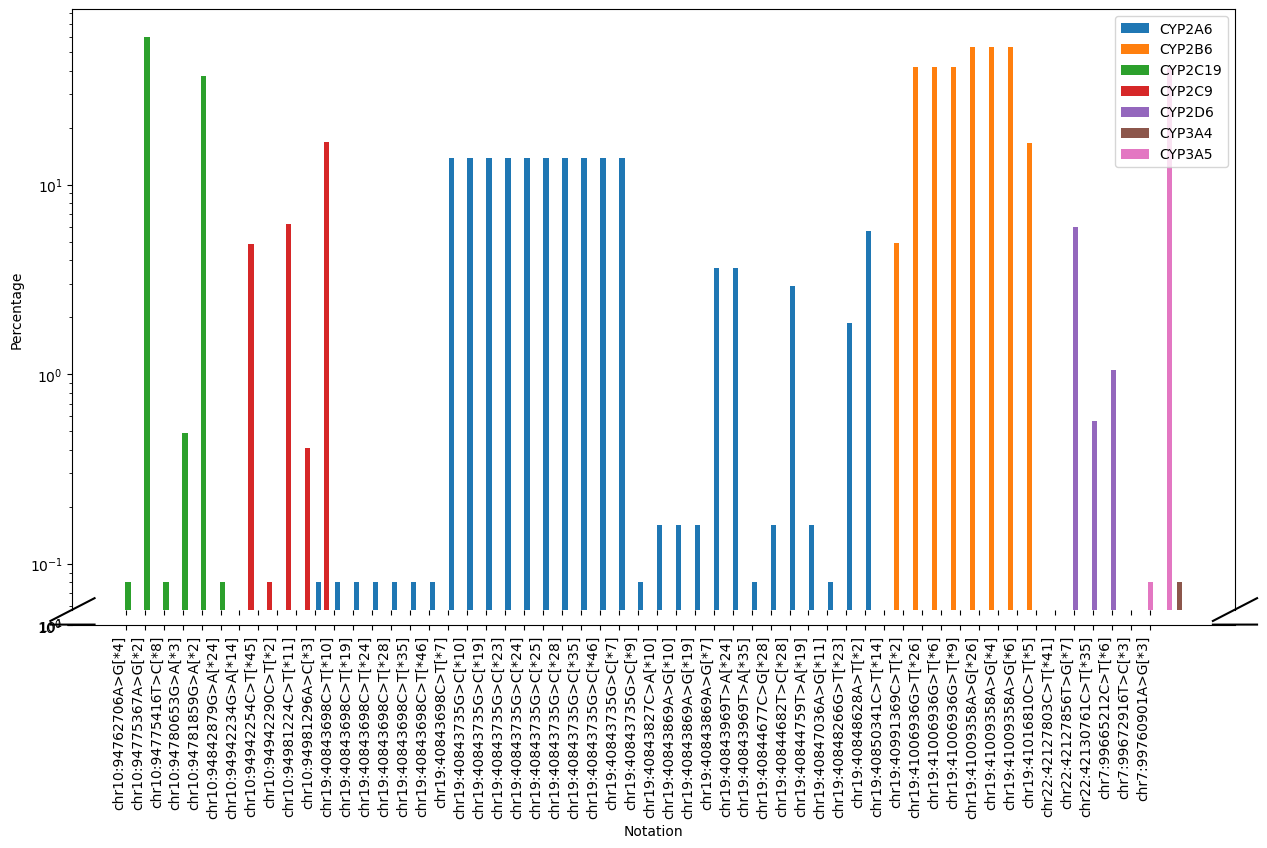

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# Replace this with your actual data
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx')

# Set the Gene column as the index
df.set_index('Gene', inplace=True)

# Create positions for bars
x = np.arange(len(df.columns))

# Set increased width of bars
width = 0.28  # Adjust the value as needed
gene_spacing = 0.2  # Adjust the value to control the gap between genes

# Create the figure and axis with increased dimensions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for each gene
for i, gene in enumerate(df.index):
    gene_offset = i * (width + gene_spacing)
    ax1.bar(x + gene_offset, df.loc[gene], width, label=gene)

# Set x-axis ticks and labels
ax2.set_xticks(x + width * (len(df.index) - 1) / 2)
ax2.set_xticklabels(df.columns, rotation=90, ha='right')  # Rotate x-axis labels

ax2.set_xlabel('Notation')

# Set y-axis label
ax1.set_ylabel('Percentage')

# Add legend
ax1.legend()

# Apply logarithmic scale to the y-axis of both subplots
ax1.set_yscale('log')
ax2.set_yscale('log')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

#plt.title('Gene Notation Bar Chart with Broken Y-axis (Log Scale)')
plt.show()

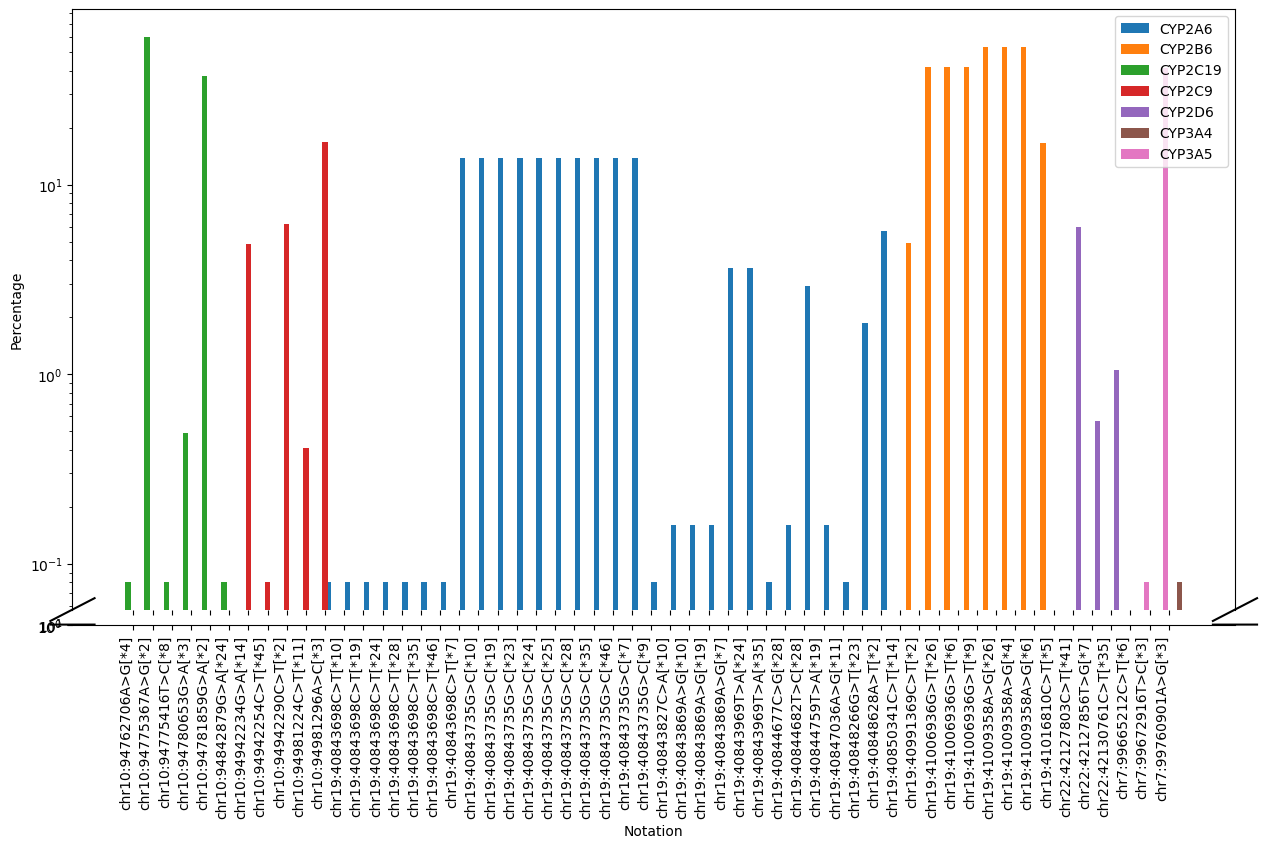

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# Replace this with your actual data
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx')

# Set the Gene column as the index
df.set_index('Gene', inplace=True)

# Create positions for bars
x = np.arange(len(df.columns))

# Set increased width of bars
width = 0.28  # Adjust the value as needed

# Create the figure and axis with increased dimensions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for each gene
for i, gene in enumerate(df.index):
    ax1.bar(x + width * i, df.loc[gene], width, label=gene)

# Set x-axis ticks and labels
ax2.set_xticks(x + width * (len(df.index) - 1) / 2)
ax2.set_xticklabels(df.columns, rotation=90, ha='right')  # Rotate x-axis labels

ax2.set_xlabel('Notation')

# Set y-axis label
ax1.set_ylabel('Percentage')

# Add legend
ax1.legend()

# Apply logarithmic scale to the y-axis of both subplots
ax1.set_yscale('log')
ax2.set_yscale('log')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

#plt.title('Gene Notation Bar Chart with Broken Y-axis (Log Scale)')
plt.show()


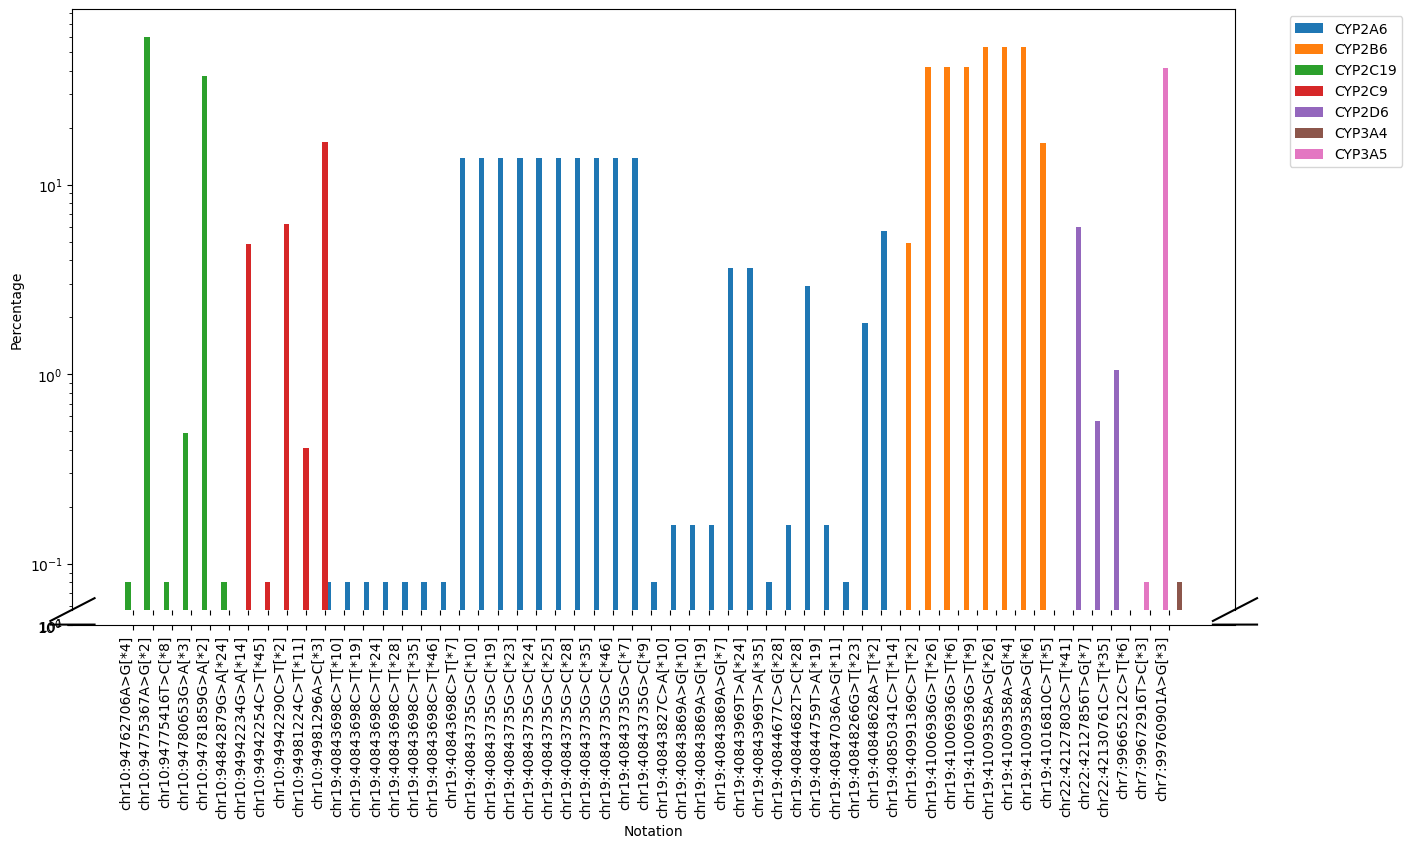

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Sample DataFrame
# Replace this with your actual data
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx')

# Set the Gene column as the index
df.set_index('Gene', inplace=True)

# Create positions for bars
x = np.arange(len(df.columns))

# Set increased width of bars
width = 0.28  # Adjust the value as needed

# Create the figure and axis with increased dimensions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for each gene
for i, gene in enumerate(df.index):
    ax1.bar(x + width * i, df.loc[gene], width, label=gene)

# Set x-axis ticks and labels
ax2.set_xticks(x + width * (len(df.index) - 1) / 2)
ax2.set_xticklabels(df.columns, rotation=90, ha='right')  # Rotate x-axis labels

ax2.set_xlabel('Notation')

# Set y-axis label
ax1.set_ylabel('Percentage')

# Apply logarithmic scale to the y-axis of both subplots
ax1.set_yscale('log')
ax2.set_yscale('log')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

# Move legend outside to the top right
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Add title
#plt.suptitle('Gene Notation Bar Chart with Broken Y-axis (Log Scale)')

# Show the plot
plt.show()

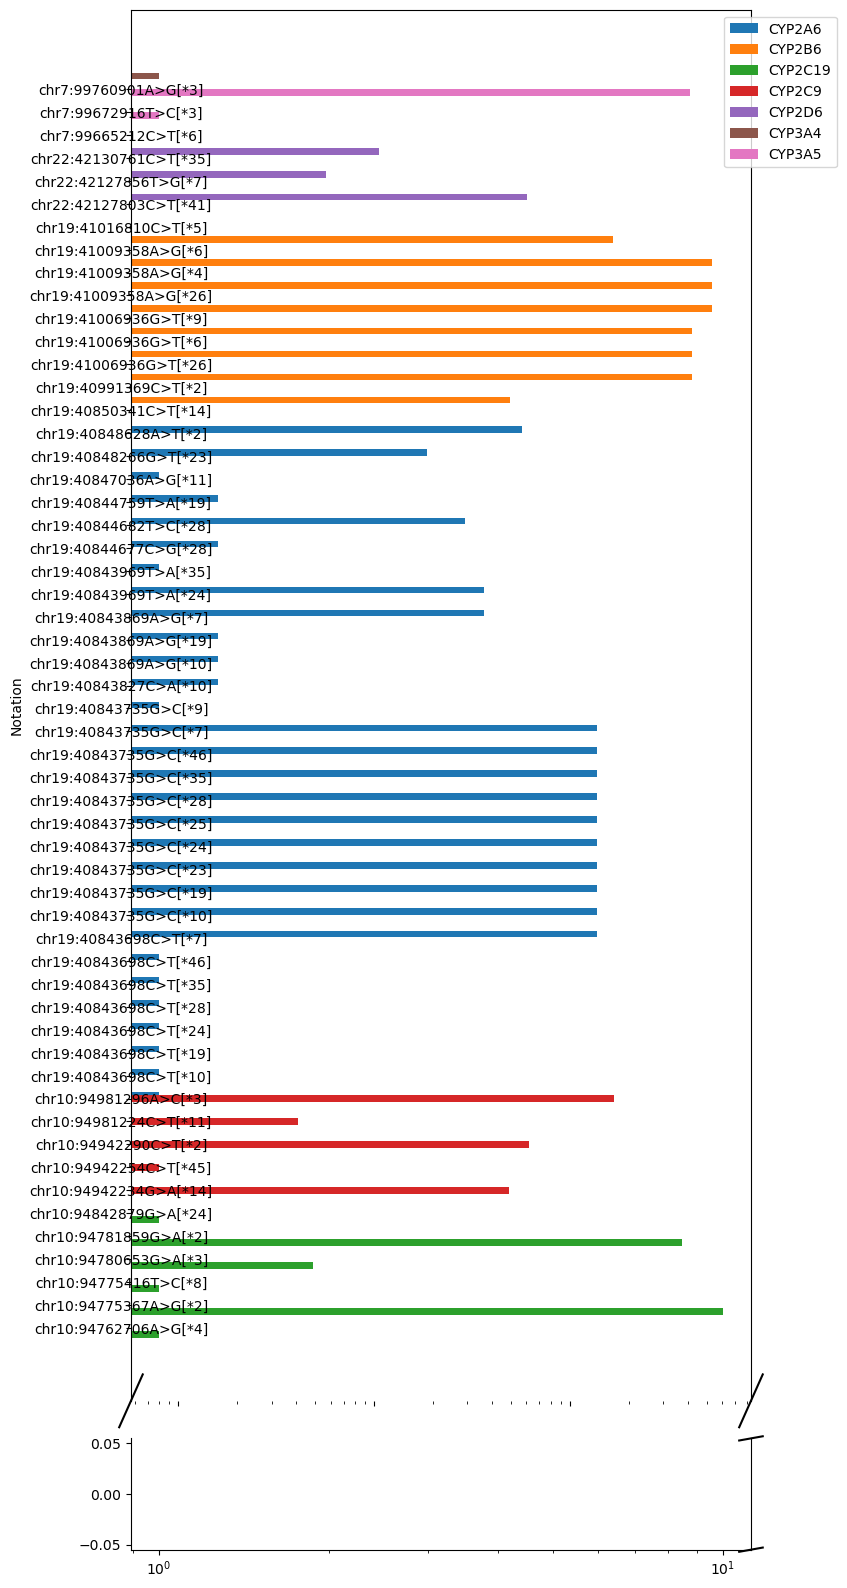

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# Replace this with your actual data
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/CYP_family_updated_pivot.xlsx')

# Set the Gene column as the index
df.set_index('Gene', inplace=True)

# Create positions for bars
y = np.arange(len(df.columns))  # Use y instead of x

# Set increased height of bars
height = 0.28  # Adjust the value as needed

# Create the figure and axis with increased dimensions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 20), gridspec_kw={'height_ratios': [2.5, 0.2]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for each gene (swap x and y)
for i, gene in enumerate(df.index):
    ax1.barh(y + height * i, df.loc[gene], height, label=gene)  # Use barh for horizontal bars

# Set y-axis ticks and labels
ax1.set_yticks(y + height * (len(df.index) - 1) / 2)
ax1.set_yticklabels(df.columns, rotation=0, ha='center')  # Rotate y-axis labels

ax1.set_ylabel('Notation')

# Set x-axis label
ax2.set_xlabel('Percentage')

# Apply logarithmic scale to the x-axis of both subplots
ax1.set_xscale('log')
ax2.set_xscale('log')

# Create a broken x-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelbottom=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([1 - d, 1 + d], [-d, +d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting x-axis label for the bottom subplot
ax2.set_xlabel('')

# Move legend outside to the top right
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Add title
#plt.suptitle('Gene Notation Bar Chart with Broken X-axis (Log Scale)')

# Show the plot
plt.show()

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data
data = {
    'Gene': ['CYP2C19', 'CYP2B6', 'CYP2B6', 'CYP2B6', 'CYP2B6', 'CYP2B6', 'CYP2B6', 'CYP3A5', 'CYP2C19', 'CYP2C9', 'CYP2B6', 'CYP2A6', 'CYP2A6', 'CYP2A6'],
    'Notation': ['chr10:94775367A>G[*2]', 'chr19:41009358A>G[*4]', 'chr19:41009358A>G[*6]', 'chr19:41009358A>G[*26]', 'chr19:41006936G>T[*6]', 'chr19:41006936G>T[*9]', 'chr19:41006936G>T[*26]', 'chr7:99672916T>C[*3]', 'chr10:94781859G>A[*2]', 'chr10:94981296A>C[*3]', 'chr19:41016810C>T[*5]', 'chr19:40843735G>C[*7]', 'chr19:40843735G>C[*9]', 'chr19:40843735G>C[*10]'],
    'Percentage': [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]
}

df = pd.DataFrame(data)
df

,Gene,Notation,Percentage
0,CYP2C19,chr10:94775367A>G[*2],60.39
1,CYP2B6,chr19:41009358A>G[*4],53.00
2,CYP2B6,chr19:41009358A>G[*6],53.00
3,CYP2B6,chr19:41009358A>G[*26],53.00
4,CYP2B6,chr19:41006936G>T[*6],41.96
5,CYP2B6,chr19:41006936G>T[*9],41.96
6,CYP2B6,chr19:41006936G>T[*26],41.96
7,CYP3A5,chr7:99672916T>C[*3],41.15
8,CYP2C19,chr10:94781859G>A[*2],37.34
9,CYP2C9,chr10:94981296A>C[*3],16.72


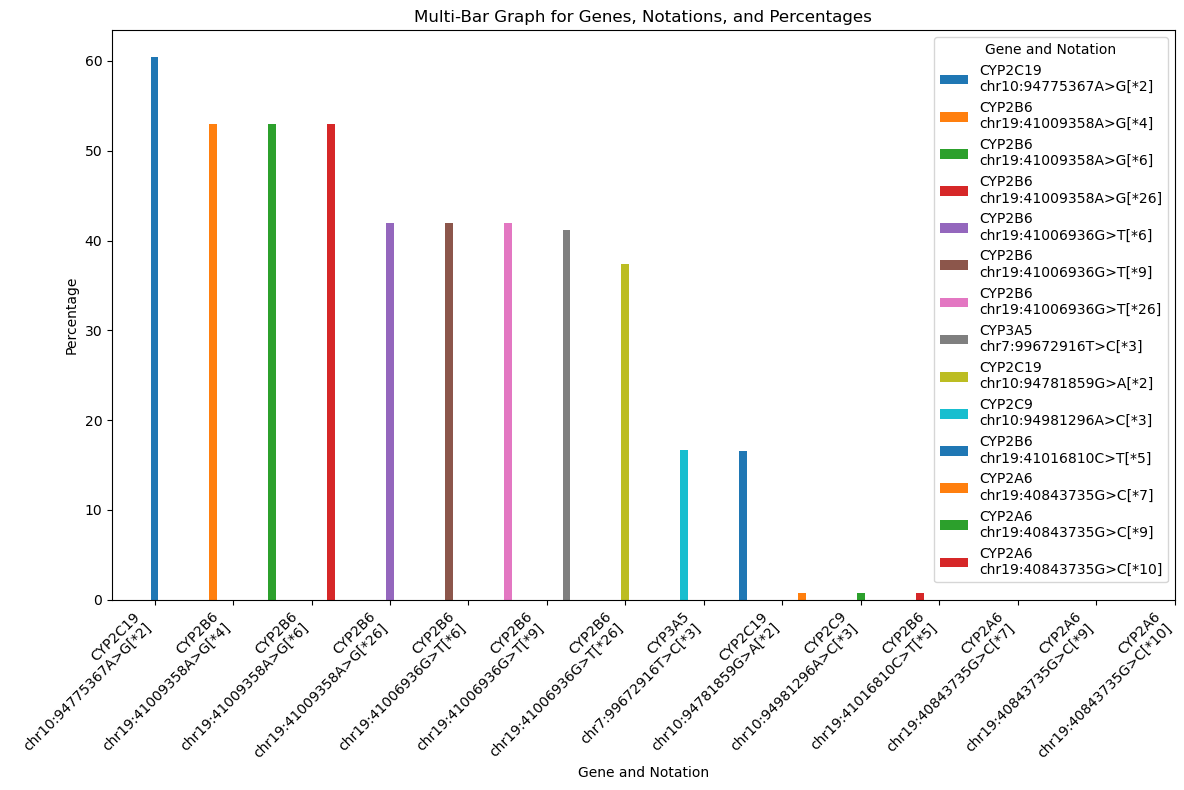

In [36]:
# Create a bar for each combination of Gene, Notation, and Percentage
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.2

for i, (gene, notation, percentage) in enumerate(zip(df['Gene'], df['Notation'], df['Percentage'])):
    x = i * 1.5  # Increase the spacing between bars
    ax.bar(x, percentage, width=width, label=f'{gene}\n{notation}')

ax.set_xlabel('Gene and Notation')
ax.set_ylabel('Percentage')
ax.set_title('Multi-Bar Graph for Genes, Notations, and Percentages')
ax.set_xticks(range(0, len(df) * 2, 2))
ax.set_xticklabels([f'{gene}\n{notation}' for gene, notation in zip(df['Gene'], df['Notation'])], rotation=45, ha='right')
ax.legend(title='Gene and Notation', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

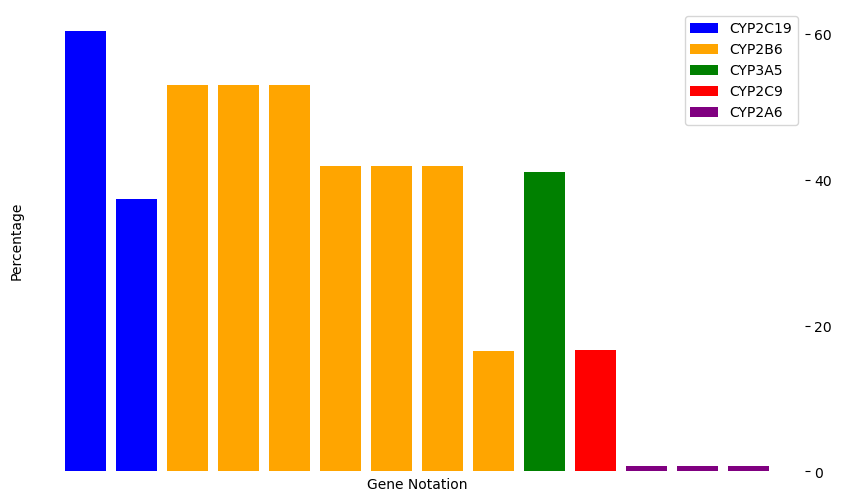

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
genes = ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"]
notations = ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"]
percentages = [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]

# Group data by gene
gene_data = {}
for gene, notation, percentage in zip(genes, notations, percentages):
    if gene not in gene_data:
        gene_data[gene] = {'notations': [], 'percentages': []}
    gene_data[gene]['notations'].append(notation)
    gene_data[gene]['percentages'].append(percentage)

# Plot broken axis multi-bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each gene
colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, (gene, data) in enumerate(gene_data.items()):
    ax.bar(data['notations'], data['percentages'], color=colors[i % len(colors)], label=gene)

# Hide the spines between ax1 and ax2
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Hide the labels between ax1 and ax2
ax.set_xticks([])
ax.set_yticks([])

# Set the x-axis label
ax.set_xlabel('Gene Notation')

# Set the y-axis label
ax.set_ylabel('Percentage')

# Create a second y-axis to show the broken axis
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks([0, 20, 40, 60])
ax2.set_yticklabels([0, 20, 40, 60])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_bounds(0, 20)
ax2.spines['bottom'].set_bounds(0, len(gene_data) * len(colors))

# Display the plot
plt.legend()
plt.show()

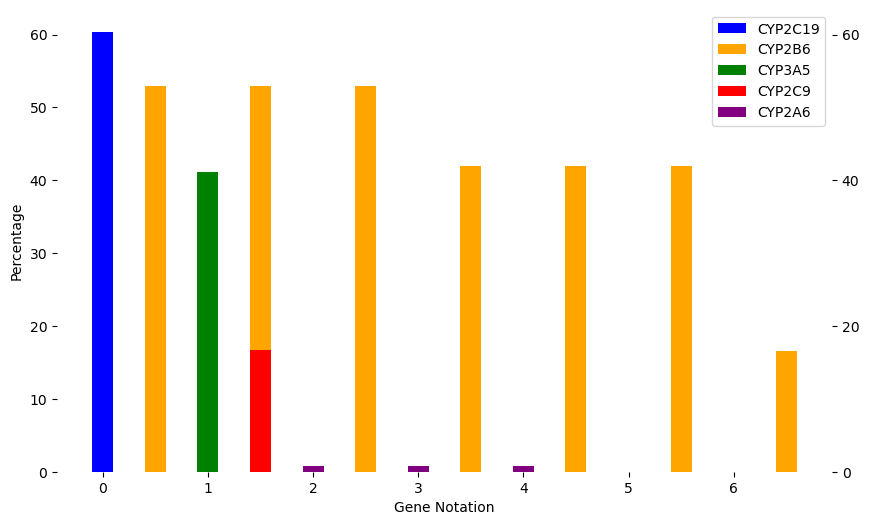

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
genes = ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"]
notations = ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"]
percentages = [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]

# Group data by gene
gene_data = {}
for gene, notation, percentage in zip(genes, notations, percentages):
    if gene not in gene_data:
        gene_data[gene] = {'notations': [], 'percentages': []}
    gene_data[gene]['notations'].append(notation)
    gene_data[gene]['percentages'].append(percentage)

# Plot broken axis multi-bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each gene
colors = ['blue', 'orange', 'green', 'red', 'purple']
bar_width = 0.2  # Adjust the width of the bars
gap = 0.3  # Adjust the gap between genes

for i, (gene, data) in enumerate(gene_data.items()):
    positions = np.arange(len(data['notations'])) + i * (bar_width + gap)
    ax.bar(positions, data['percentages'], width=bar_width, color=colors[i % len(colors)], label=gene)

# Hide the spines between ax1 and ax2
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Set the x-axis label
ax.set_xlabel('Gene Notation')

# Set the y-axis label
ax.set_ylabel('Percentage')

# Create a second y-axis to show the broken axis
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks([0, 20, 40, 60])
ax2.set_yticklabels([0, 20, 40, 60])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_bounds(0, 20)
ax2.spines['bottom'].set_bounds(0, len(gene_data) * (bar_width + gap))

# Display the plot
plt.legend()
plt.show()

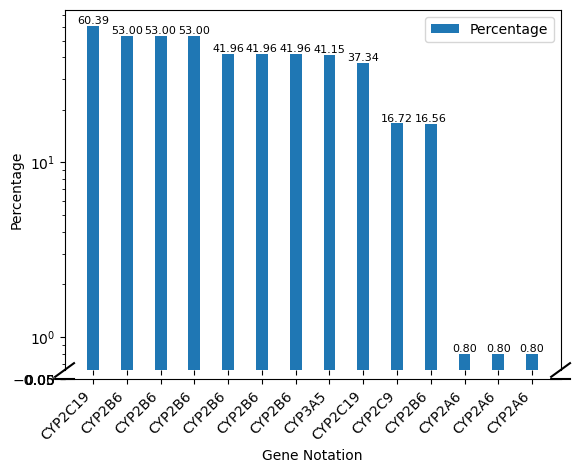

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {
    'Gene': ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"],
    'Notation': ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"],
    'Percentage': [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]
}

df = pd.DataFrame(data)

# Create positions for bars
x = np.arange(len(df))

# Set width of bars
width = 0.35

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for Percentage
percentage_bars = ax1.bar(x, df['Percentage'], width, label='Percentage')

# Apply logarithmic scale to the y-axis of the top subplot
ax1.set_yscale('log')

# Setting y-axis label for the top subplot
ax1.set_ylabel('Percentage')

# Add labels inside the bars
for bar in percentage_bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

# Set x-axis ticks and labels
ax2.set_xticks(x)
ax2.set_xticklabels(df['Notation'], rotation=45, ha='right')

# Set custom x-axis labels
custom_labels = df['Gene']
ax2.set_xticklabels(custom_labels)

ax2.set_xlabel('Gene Notation')

# Adding legend to the top subplot
ax1.legend()

#plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/2_madhu_sample.png', dpi=2000, bbox_inches='tight')

# Show the plot
plt.show()


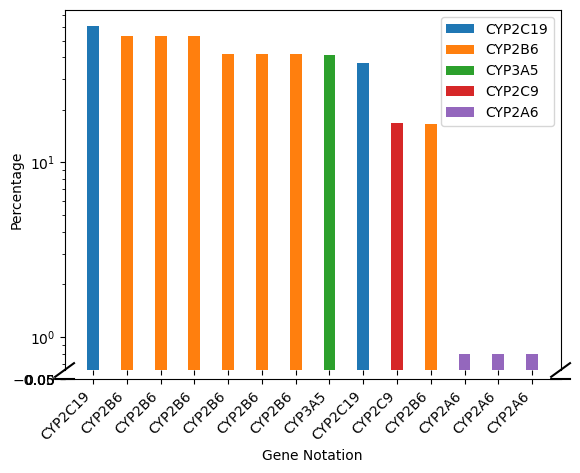

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {
    'Gene': ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"],
    'Notation': ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"],
    'Percentage': [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]
}

df = pd.DataFrame(data)

# Create positions for bars
x = np.arange(len(df))

# Set width of bars
width = 0.35

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Group data by gene and create separate x positions for each gene
gene_data = {}
for i, (gene, notation, percentage) in enumerate(zip(df['Gene'], df['Notation'], df['Percentage'])):
    if gene not in gene_data:
        gene_data[gene] = {'x': [], 'percentages': []}
    gene_data[gene]['x'].append(i)
    gene_data[gene]['percentages'].append(percentage)

# Bar chart for Percentage
for gene, data in gene_data.items():
    ax1.bar(data['x'], data['percentages'], width, label=gene)

# Apply logarithmic scale to the y-axis of the top subplot
ax1.set_yscale('log')

# Setting y-axis label for the top subplot
ax1.set_ylabel('Percentage')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

# Set x-axis ticks and labels
ax2.set_xticks(x)
ax2.set_xticklabels(df['Notation'], rotation=45, ha='right')

# Set custom x-axis labels
custom_labels = df['Gene']
ax2.set_xticklabels(custom_labels)

ax2.set_xlabel('Gene Notation')

# Adding legend to the top subplot
ax1.legend()

# Save or show the plot
#plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/2_madhu_sample.png', dpi=2000, bbox_inches='tight')
plt.show()

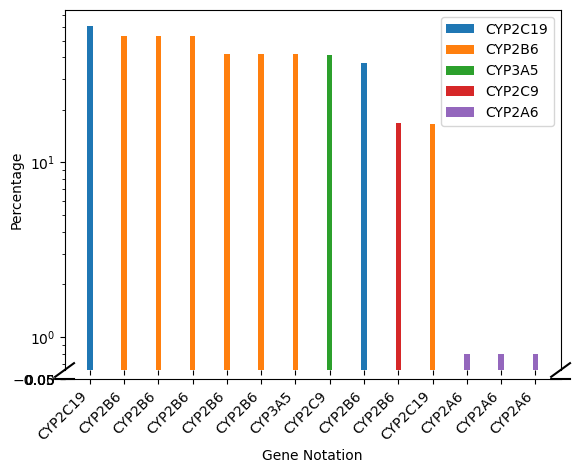

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {
    'Gene': ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"],
    'Notation': ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"],
    'Percentage': [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]
}

df = pd.DataFrame(data)

# Group data by gene and create separate x positions for each gene
gene_data = {}
for i, (gene, notation, percentage) in enumerate(zip(df['Gene'], df['Notation'], df['Percentage'])):
    if gene not in gene_data:
        gene_data[gene] = {'x': [], 'percentages': []}
    gene_data[gene]['x'].append(i)

# Create positions for bars
x = [item for sublist in gene_data.values() for item in sublist['x']]
width = 0.8 / len(gene_data)  # Adjust the width to eliminate gaps

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for Percentage
for gene, data in gene_data.items():
    ax1.bar(data['x'], [df.loc[i, 'Percentage'] for i in data['x']], width, label=gene)

# Apply logarithmic scale to the y-axis of the top subplot
ax1.set_yscale('log')

# Setting y-axis label for the top subplot
ax1.set_ylabel('Percentage')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

# Set x-axis ticks and labels
ax2.set_xticks(x)
ax2.set_xticklabels(df['Notation'], rotation=45, ha='right')

# Set custom x-axis labels
custom_labels = df['Gene']
ax2.set_xticklabels(custom_labels)

ax2.set_xlabel('Gene Notation')

# Adding legend to the top subplot
ax1.legend()

# Save or show the plot
# plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/2_madhu_sample.png', dpi=2000, bbox_inches='tight')
plt.show()


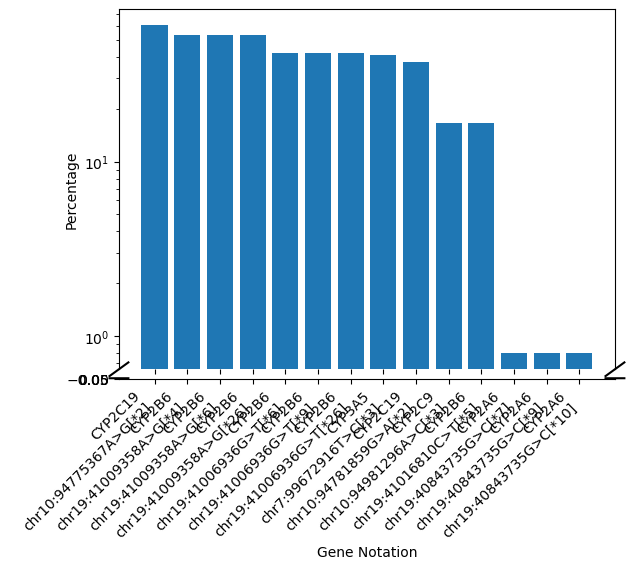

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {
    'Gene': ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"],
    'Notation': ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"],
    'Percentage': [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]
}

df = pd.DataFrame(data)

# Group data by gene and notation and create separate x positions for each group
gene_notation_data = {}
x_positions = []
for i, (gene, notation, percentage) in enumerate(zip(df['Gene'], df['Notation'], df['Percentage'])):
    gene_notation = f"{gene}-{notation}"
    if gene_notation not in gene_notation_data:
        gene_notation_data[gene_notation] = {'x': i, 'percentage': percentage}
        x_positions.append(i)

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2000, 2.5]})
plt.subplots_adjust(hspace=0.05)

# Bar chart for Percentage
ax1.bar(x_positions, [gene_notation_data[f"{df.loc[i, 'Gene']}-{df.loc[i, 'Notation']}"]['percentage'] for i in range(len(df))])

# Apply logarithmic scale to the y-axis of the top subplot
ax1.set_yscale('log')

# Setting y-axis label for the top subplot
ax1.set_ylabel('Percentage')

# Create a broken y-axis for the bottom subplot
ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

d = .019
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot([-d, +d], [-d, +d], **kwargs)
ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax2.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# Setting y-axis label for the bottom subplot
ax2.set_ylabel('')

# Set x-axis ticks and labels
ax2.set_xticks(x_positions)
ax2.set_xticklabels([f"{df.loc[i, 'Gene']}\n{df.loc[i, 'Notation']}" for i in range(len(df))], rotation=45, ha='right')

# Set custom x-axis labels
ax2.set_xlabel('Gene Notation')

# Save or show the plot
# plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/2_madhu_sample.png', dpi=2000, bbox_inches='tight')
plt.show()


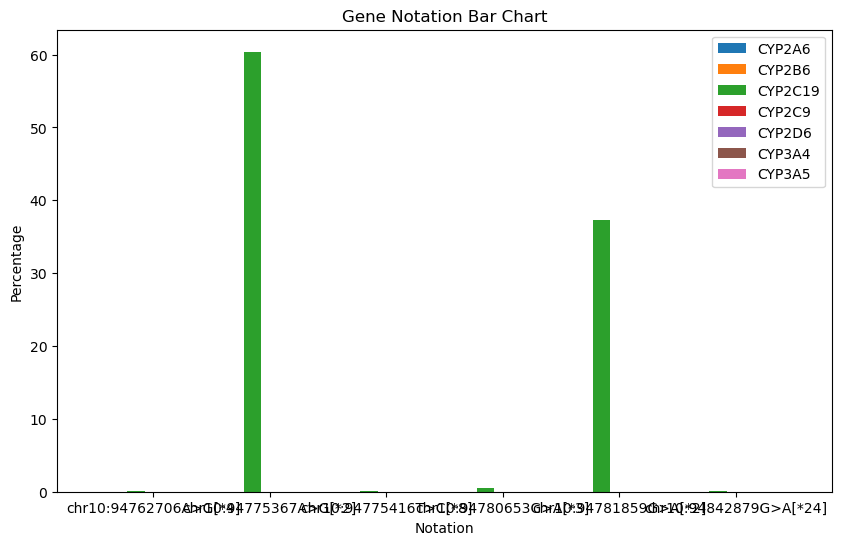

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
data = {
    'Gene': ["CYP2A6", "CYP2B6", "CYP2C19", "CYP2C9", "CYP2D6", "CYP3A4", "CYP3A5"],
    'chr10:94762706A>G[*4]': [0, 0, 0.08, 0, 0, 0, 0],
    'chr10:94775367A>G[*2]': [0, 0, 60.39, 0, 0, 0, 0],
    'chr10:94775416T>C[*8]': [0, 0, 0.08, 0, 0, 0, 0],
    'chr10:94780653G>A[*3]': [0, 0, 0.49, 0, 0, 0, 0],
    'chr10:94781859G>A[*2]': [0, 0, 37.34, 0, 0, 0, 0],
    'chr10:94842879G>A[*24]': [0, 0, 0.08, 0, 0, 0, 0],
}

df = pd.DataFrame(data)

# Set the Gene column as the index
df.set_index('Gene', inplace=True)

# Create positions for bars
x = np.arange(len(df.columns))

# Set width of bars
width = 0.15

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for each gene
for i, gene in enumerate(df.index):
    ax.bar(x + width * i, df.loc[gene], width, label=gene)

# Set x-axis ticks and labels
ax.set_xticks(x + width * (len(df.index) - 1) / 2)
ax.set_xticklabels(df.columns)
ax.set_xlabel('Notation')

# Set y-axis label
ax.set_ylabel('Percentage')

# Add legend
ax.legend()

plt.title('Gene Notation Bar Chart')
plt.show()


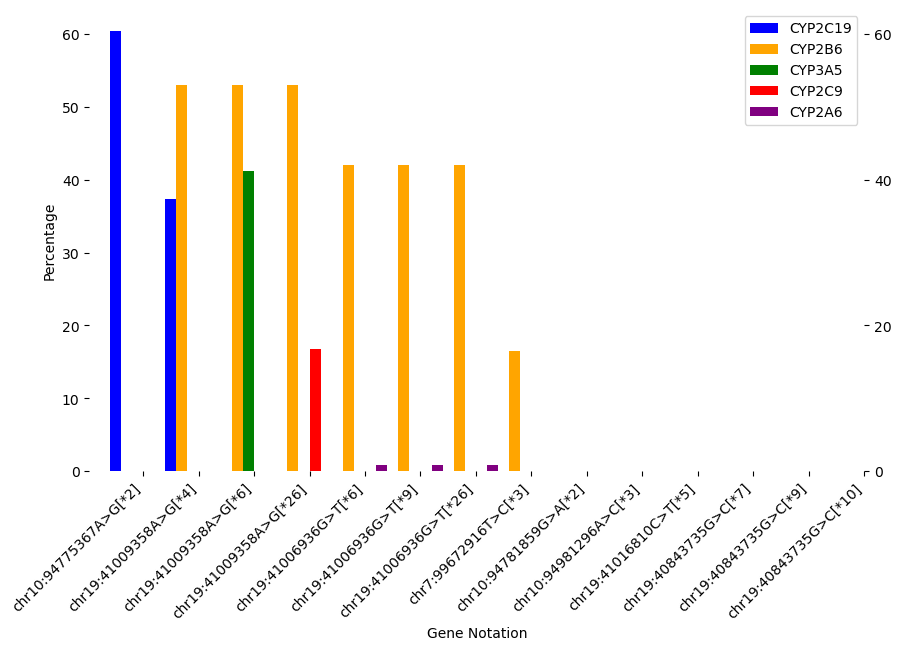

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
genes = ["CYP2C19", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP2B6", "CYP3A5", "CYP2C19", "CYP2C9", "CYP2B6", "CYP2A6", "CYP2A6", "CYP2A6"]
notations = ["chr10:94775367A>G[*2]", "chr19:41009358A>G[*4]", "chr19:41009358A>G[*6]", "chr19:41009358A>G[*26]", "chr19:41006936G>T[*6]", "chr19:41006936G>T[*9]", "chr19:41006936G>T[*26]", "chr7:99672916T>C[*3]", "chr10:94781859G>A[*2]", "chr10:94981296A>C[*3]", "chr19:41016810C>T[*5]", "chr19:40843735G>C[*7]", "chr19:40843735G>C[*9]", "chr19:40843735G>C[*10]"]
percentages = [60.39, 53, 53, 53, 41.96, 41.96, 41.96, 41.15, 37.34, 16.72, 16.56, 0.8, 0.8, 0.8]

# Group data by gene
gene_data = {}
for gene, notation, percentage in zip(genes, notations, percentages):
    if gene not in gene_data:
        gene_data[gene] = {'notations': [], 'percentages': []}
    gene_data[gene]['notations'].append(notation)
    gene_data[gene]['percentages'].append(percentage)

# Plot broken axis multi-bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each gene with gaps
colors = ['blue', 'orange', 'green', 'red', 'purple']
bar_width = 0.2  # Adjust this value based on your preference

for i, (gene, data) in enumerate(gene_data.items()):
    x_positions = np.arange(len(data['notations'])) + i * (len(gene_data) + 1) * bar_width
    ax.bar(x_positions, data['percentages'], width=bar_width, color=colors[i % len(colors)], label=gene)

# Hide the spines between ax1 and ax2
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Set the x-axis ticks and labels
ax.set_xticks([])
ax.set_xticks(np.arange(len(notations)) + 0.5 * len(gene_data) * bar_width)
ax.set_xticklabels(notations, rotation=45, ha='right')

# Set the x-axis label
ax.set_xlabel('Gene Notation')

# Set the y-axis label
ax.set_ylabel('Percentage')

# Create a second y-axis to show the broken axis
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks([0, 20, 40, 60])
ax2.set_yticklabels([0, 20, 40, 60])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_bounds(0, 20)
ax2.spines['bottom'].set_bounds(0, len(gene_data) * (len(gene_data) + 1) * bar_width)

# Display the plot
plt.legend()
plt.show()

In [14]:
data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/Haplotypes_1_12_2023/6_genes.csv')
data

,Gene,Notation,Percentage
0,G6PD,chrX:154531643C>T[*ClinVar],59.17
1,G6PD,chrX:154532247G>A[*ClinVar],1.06
2,G6PD,chrX:154532293G>A[*ClinVar],58.52
3,G6PD,chrX:154532439A>G[*ClinVar],62.34
4,G6PD,chrX:154532806C>T[*ClinVar],0.08
5,G6PD,chrX:154534115G>A[*ClinVar],0.73
6,G6PD,chrX:154535176C>G[*ClinVar],1.14
7,G6PD,chrX:154535342C>T[*ClinVar],0.08
8,G6PD,"chrX:154533044C>T[*Kalyan-Kerala, Jamnaga, Roh...",1.87
9,G6PD,chrX:154534495C>T[*Mahidol],0.24


# Gene,and POS mapping

In [30]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/1232_PGx_unique_star_alleles_Function_Evidence.xlsx')
df = df[['CHROM', 'POS', 'REF', 'ALT', 'rsID', 'Gene', 'Gene_star_allele_updated']]

data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX1_snp_pos_distance.xlsx')
data['HET'] = data['INFO'].str.extract(r'HET=(\d)')
data['HOM'] = data['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
data['Zygosity'] = ''
data.loc[data['HOM'] == '1', 'Zygosity'] = 'Homozygous'
data.loc[data['HET'] == '1', 'Zygosity'] = 'Heterozygous'
data = data[data['Haplotype'] == 'Snp']
data = data[['CHROM', 'POS', 'REF', 'ALT', 'rsID', 'Covered/Not_Covered', 'Gene', 'Zygosity']]
# Function to find the nearest POS and corresponding 'Gene_star_allele_updated'
def find_nearest_pos(row):
    df2_subset = df[df['Gene'] == row['Gene']]
    if not df2_subset.empty:
        nearest_pos_index = (df2_subset['POS'] - row['POS']).abs().idxmin()
        nearest_pos = df2_subset.loc[nearest_pos_index, 'POS']
        nearest_gene_star_allele_updated = df2_subset.loc[nearest_pos_index, 'Gene_star_allele_updated']
        return nearest_pos, nearest_gene_star_allele_updated
    else:
        return None, None

# Apply the function to create 'POS_df2' and 'Gene_star_allele_df2' columns in data
data[['POS_df2', 'Gene_star_allele_df2']] = data.apply(find_nearest_pos, axis=1, result_type='expand')
data['POS_diff'] = data['POS_df2'] - data['POS']
data = data.dropna(subset=['POS_df2'])
data

,CHROM,POS,REF,ALT,rsID,Covered/Not_Covered,Gene,Zygosity,POS_df2,Gene_star_allele_df2,POS_diff
0,chr6,18128428,T,A,rs7886,Covered,TPMT,Heterozygous,18130687.0,TPMT*3C,2259.0
1,chr7,99662739,C,A,rs4646453,Covered,CYP3A5,Heterozygous,99672916.0,CYP3A5*3,10177.0
12,chr10,94762804,C,T,rs17885098,Covered,CYP2C19,Homozygous,94780653.0,CYP2C19*3,17849.0
13,chr10,94942093,T,C,rs9332120,Covered,CYP2C9,Homozygous,94942234.0,CYP2C9*14,141.0
14,chr12,21239628,T,G,rs4149087,Covered,SLCO1B1,Heterozygous,21178615.0,SLCO1B1*5,-61013.0
15,chr12,21239652,A,G,rs4149088,Covered,SLCO1B1,Heterozygous,21178615.0,SLCO1B1*5,-61037.0
16,chr13,48040905,G,C,rs747497670,Covered,NUDT15,Heterozygous,48045719.0,NUDT15*3,4814.0
17,chr19,40849944,A,G,rs2302990,Covered,CYP2A6,Heterozygous,40850341.0,CYP2A6*14,397.0
18,chr19,40849991,T,C,rs376970015,Covered,CYP2A6,Heterozygous,40850341.0,CYP2A6*14,350.0
19,chr19,41006887,C,T,rs4803419,Covered,CYP2B6,Homozygous,41006936.0,CYP2B6*9,49.0


In [23]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX1_snp_pos_distance.xlsx')
data['HET'] = data['INFO'].str.extract(r'HET=(\d)')
data['HOM'] = data['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
data['Zygosity'] = ''
data.loc[data['HOM'] == '1', 'Zygosity'] = 'Homozygous'
data.loc[data['HET'] == '1', 'Zygosity'] = 'Heterozygous'
data = data[data['Haplotype'] == 'Snp']
data = data[['CHROM', 'POS', 'REF', 'ALT', 'rsID', 'Covered/Not_Covered', 'Gene', 'Zygosity']]
data

,CHROM,POS,REF,ALT,rsID,Covered/Not_Covered,Gene,Zygosity
0,chr6,18128428,T,A,rs7886,Covered,TPMT,Heterozygous
1,chr7,99662739,C,A,rs4646453,Covered,CYP3A5,Heterozygous
2,chr7,99763843,C,T,rs2242480,Covered,CYP3A4,Homozygous
12,chr10,94762804,C,T,rs17885098,Covered,CYP2C19,Homozygous
13,chr10,94942093,T,C,rs9332120,Covered,CYP2C9,Homozygous
14,chr12,21239628,T,G,rs4149087,Covered,SLCO1B1,Heterozygous
15,chr12,21239652,A,G,rs4149088,Covered,SLCO1B1,Heterozygous
16,chr13,48040905,G,C,rs747497670,Covered,NUDT15,Heterozygous
17,chr19,40849944,A,G,rs2302990,Covered,CYP2A6,Heterozygous
18,chr19,40849991,T,C,rs376970015,Covered,CYP2A6,Heterozygous


In [29]:
# Function to find the nearest POS and corresponding 'Gene_star_allele_updated'
def find_nearest_pos(row):
    df2_subset = df[df['Gene'] == row['Gene']]
    if not df2_subset.empty:
        nearest_pos_index = (df2_subset['POS'] - row['POS']).abs().idxmin()
        nearest_pos = df2_subset.loc[nearest_pos_index, 'POS']
        nearest_gene_star_allele_updated = df2_subset.loc[nearest_pos_index, 'Gene_star_allele_updated']
        return nearest_pos, nearest_gene_star_allele_updated
    else:
        return None, None

# Apply the function to create 'POS_df2' and 'Gene_star_allele_df2' columns in data
data[['POS_df2', 'Gene_star_allele_df2']] = data.apply(find_nearest_pos, axis=1, result_type='expand')
data['POS_diff'] = data['POS_df2'] - data['POS']
data = data.dropna(subset=['POS_df2'])
data

,CHROM,POS,REF,ALT,rsID,Covered/Not_Covered,Gene,Zygosity,POS_df2,Gene_star_allele_df2,POS_diff
0,chr6,18128428,T,A,rs7886,Covered,TPMT,Heterozygous,18130687.0,TPMT*3C,2259.0
1,chr7,99662739,C,A,rs4646453,Covered,CYP3A5,Heterozygous,99672916.0,CYP3A5*3,10177.0
12,chr10,94762804,C,T,rs17885098,Covered,CYP2C19,Homozygous,94780653.0,CYP2C19*3,17849.0
13,chr10,94942093,T,C,rs9332120,Covered,CYP2C9,Homozygous,94942234.0,CYP2C9*14,141.0
14,chr12,21239628,T,G,rs4149087,Covered,SLCO1B1,Heterozygous,21178615.0,SLCO1B1*5,-61013.0
15,chr12,21239652,A,G,rs4149088,Covered,SLCO1B1,Heterozygous,21178615.0,SLCO1B1*5,-61037.0
16,chr13,48040905,G,C,rs747497670,Covered,NUDT15,Heterozygous,48045719.0,NUDT15*3,4814.0
17,chr19,40849944,A,G,rs2302990,Covered,CYP2A6,Heterozygous,40850341.0,CYP2A6*14,397.0
18,chr19,40849991,T,C,rs376970015,Covered,CYP2A6,Heterozygous,40850341.0,CYP2A6*14,350.0
19,chr19,41006887,C,T,rs4803419,Covered,CYP2B6,Homozygous,41006936.0,CYP2B6*9,49.0


In [ ]:
KHAIGPRX959_final_DP

In [358]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX959_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
df[df['rsID'] == 'rs1799931']

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity
51,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=41;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:44:41:41:27:13:31.71%:3.8184E-5:68:59:24:3...,Heterozygous


# data_new added

In [349]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX9_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity
0,chr1,11786390,rs4845884,G,A,.,PASS,"ADP=80;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.06669,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:80:80:0:80:100%:1.0864E-47:0:54:0:0:64:16,Homozygous
1,chr1,11787702,rs3737966,C,T,.,PASS,"ADP=38;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.4415,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:218:38:38:0:38:100%:1.4508E-22:0:37:0:0:16:22,Homozygous
2,chr1,11788822,rs2077360,A,G,.,PASS,"ADP=36;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.06949,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:206:36:36:0:36:100%:2.2598E-21:0:54:0:0:21:15,Homozygous
3,chr1,11789390,rs868014,A,G,.,PASS,"ADP=51;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.06709,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:51:51:0:51:100%:2.5024E-30:0:58:0:0:35:16,Homozygous
4,chr1,11790308,rs4846049,T,G,.,PASS,"ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.3716,.,...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:254:44:44:0:44:100%:3.8097E-26:0:55:0:0:34:10,Homozygous
...,...,...,...,...,...,...,...,...,...,...,...
212,chr21,45531642,rs12659,A,G,.,PASS,"ADP=100;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.4469,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:100:100:0:100:100%:1.1044E-59:0:53:0:0...,Homozygous
213,chr21,45532180,rs914231,T,C,.,PASS,"ADP=47;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.4856,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:47:47:0:47:100%:6.1512E-28:0:55:0:0:30:17,Homozygous
214,chr21,45535988,rs374483779,C,A,.,PASS,"ADP=48;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9962,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:98:48:48:22:26:54.17%:1.3341E-10:60:47:22:...,Heterozygous
215,chr21,45538002,rs1131596,G,A,.,PASS,"ADP=26;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5246,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:146:26:26:0:26:100%:2.0165E-15:0:38:0:0:6:20,Homozygous


In [350]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/RSIDS_POSITION_DBSNP.xlsx')
data

,CHROM,POS,REF,ALT,rsID_updated
0,chr6,18130687,T,A,rs1142345
1,chr6,18130687,T,C,rs1142345
2,chr6,18130687,T,G,rs1142345
3,chr6,18138997,C,A,rs1800460
4,chr6,18138997,C,T,rs1800460
5,chr8,18400285,C,T,rs1041983
6,chr8,18400344,T,A,rs1801280
7,chr8,18400344,T,C,rs1801280
8,chr8,18400484,C,T,rs1799929
9,chr8,18400593,G,A,rs1799930


In [351]:
df = pd.merge(df, data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort = False)
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280
2,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:70:51:51:31:20:39.22%:9.3266E-8:56:51:24:7...,Heterozygous,rs1799929
3,chr8,18400806,rs1208,G,A,.,PASS,"ADP=58;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:103:58:58:30:28:48.28%:4.8441E-11:56:56:21...,Heterozygous,rs1208
4,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=47;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:84:47:47:24:23:48.94%:3.2602E-9:57:51:16:8...,Heterozygous,rs1799931
5,chr12,21176804,rs2306283,A,G,.,PASS,"ADP=60;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3776,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:93:60:60:34:26:43.33%:4.5813E-10:56:62:27:...,Heterozygous,rs2306283
6,chr19,40843735,rs7248240,G,C,.,PASS,"ADP=36;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.4483,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:36:36:22:14:38.89%:1.2704E-5:44:46:22:0...,Heterozygous,rs7248240
7,chr19,41006936,rs3745274,G,T,.,PASS,ADP=49;WT=0;HET=1;HOM=0;NC=0;ASP;ASS;CAF=0.684...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:118:49:49:19:30:61.22%:1.3155E-12:60:54:18...,Heterozygous,rs3745274


In [352]:
data = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/13_Genes_Key_Variants_Coordinates.csv', sep = '\t')
data = data[['CHROM', 'POS', 'REF', 'ALT', 'Haplotype']]
data.head()

,CHROM,POS,REF,ALT,Haplotype
0,chr19,40848628.0,A,T,CYP2A6*2
1,chr19,40843869.0,A,G,CYP2A6*7
2,chr19,40843749.0,CC,C,CYP2A6*7
3,chr19,40843746.0,T,C,CYP2A6*7
4,chr19,40843742.0,G,A,CYP2A6*7


In [353]:
df = pd.merge(df, data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'left', sort = False)
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated,Haplotype
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*4
1,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6A
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6J
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6O
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*7B
5,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*7G
6,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*13A
7,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*4
8,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*5A
9,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*5B


In [354]:
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ','.join(set(x)))

# Create a Zygosity_mapped column where each row contains the corresponding Zygosity values for rsIDs in rsID_mapped
df['Zygosity_mapped'] = df.apply(lambda row: ','.join(row['Zygosity'] for rsID in row['rsID_mapped'].split(',')), axis=1)

# Create a new column with corresponding rsID and Zygosity pairs
df.drop_duplicates(subset='Haplotype', inplace=True)
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated,Haplotype,rsID_mapped,Zygosity_mapped
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*4,"rs1801280,rs1799929,rs1208,rs1041983,rs1799931","Heterozygous,Heterozygous,Heterozygous,Heteroz..."
1,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6A,rs1041983,Heterozygous
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6J,"rs1799931,rs1041983","Heterozygous,Heterozygous"
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*6O,rs1041983,Heterozygous
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*7B,"rs1799931,rs1041983","Heterozygous,Heterozygous"
5,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*7G,"rs1799931,rs1041983","Heterozygous,Heterozygous"
6,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983,NAT2*13A,rs1041983,Heterozygous
8,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*5A,"rs1801280,rs1799929","Heterozygous,Heterozygous"
9,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*5B,"rs1801280,rs1799929,rs1208","Heterozygous,Heterozygous,Heterozygous"
10,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280,NAT2*5C,"rs1801280,rs1208","Heterozygous,Heterozygous"


In [317]:
df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sample_data.xlsx', index=False)

In [348]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
data

,Haplotype_updated,rsID_mapped
0,NAT2*7B,"rs1041983,rs1799931"
1,NAT2*7G,"rs1041983,rs1799931,chr8_18400229_T_G"
2,CYP2D6*10,"rs1135840,rs1058164,rs1065852"
3,CYP2D6*2,"rs1135840,rs16947,rs1058164"
4,NAT2*6A,"rs1799930,rs1041983"
5,NAT2*6J,"rs1799930,rs1041983,rs1799931"
6,NAT2*6O,"rs1799930,rs1041983,rs56393504"
7,TPMT*3A,"rs1800460,rs1142345"
8,NAT2*5C,"rs1801280,rs1208"
9,NAT2*5A,"rs1801280,rs1799929"


In [335]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX9_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/RSIDS_POSITION_DBSNP.xlsx')

df = pd.merge(df, data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort = False)
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
# Split the values in 'rsID_mapped' column into lists
data['rsID_mapped'] = data['rsID_mapped'].apply(lambda x: x.split(','))
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,rs1041983
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,rs1801280
2,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:70:51:51:31:20:39.22%:9.3266E-8:56:51:24:7...,Heterozygous,rs1799929
3,chr8,18400806,rs1208,G,A,.,PASS,"ADP=58;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:103:58:58:30:28:48.28%:4.8441E-11:56:56:21...,Heterozygous,rs1208
4,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=47;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:84:47:47:24:23:48.94%:3.2602E-9:57:51:16:8...,Heterozygous,rs1799931
5,chr12,21176804,rs2306283,A,G,.,PASS,"ADP=60;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3776,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:93:60:60:34:26:43.33%:4.5813E-10:56:62:27:...,Heterozygous,rs2306283
6,chr19,40843735,rs7248240,G,C,.,PASS,"ADP=36;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.4483,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:36:36:22:14:38.89%:1.2704E-5:44:46:22:0...,Heterozygous,rs7248240
7,chr19,41006936,rs3745274,G,T,.,PASS,ADP=49;WT=0;HET=1;HOM=0;NC=0;ASP;ASS;CAF=0.684...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:118:49:49:19:30:61.22%:1.3155E-12:60:54:18...,Heterozygous,rs3745274


,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=59;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:116:59:59:28:31:52.54%:2.0466E-12:63:55:25...,Heterozygous,"rs1041983,rs1799931"
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,Heterozygous,"rs1801280,rs1208"
2,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=51;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:70:51:51:31:20:39.22%:9.3266E-8:56:51:24:7...,Heterozygous,"rs1801280,rs1799929"
3,chr8,18400806,rs1208,G,A,.,PASS,"ADP=58;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:103:58:58:30:28:48.28%:4.8441E-11:56:56:21...,Heterozygous,"rs1801280,rs1208"
4,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=47;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:84:47:47:24:23:48.94%:3.2602E-9:57:51:16:8...,Heterozygous,"rs1041983,rs1799931"
5,chr12,21176804,rs2306283,A,G,.,PASS,"ADP=60;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3776,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:93:60:60:34:26:43.33%:4.5813E-10:56:62:27:...,Heterozygous,"rs2306283,rs11045819"
6,chr19,40843735,rs7248240,G,C,.,PASS,"ADP=36;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.4483,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:36:36:22:14:38.89%:1.2704E-5:44:46:22:0...,Heterozygous,"rs28399433,rs7248240"
7,chr19,41006936,rs3745274,G,T,.,PASS,ADP=49;WT=0;HET=1;HOM=0;NC=0;ASP;ASS;CAF=0.684...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:118:49:49:19:30:61.22%:1.3155E-12:60:54:18...,Heterozygous,"rs3745274,rs2279343"


In [336]:
gene_summary = df.groupby('rsID_updated').agg({'Zygosity': lambda x: ','.join(x)}).reset_index()
gene_summary = gene_summary[gene_summary['Zygosity'].str.contains(",")]
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
gene_summary = gene_summary.rename({'rsID_updated':'rsID_mapped'}, axis = 1)
mapped = pd.merge(gene_summary, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,Zygosity,Haplotype_updated,rsID_mapped


## main

In [ ]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX9_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

In [341]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX981_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/RSIDS_POSITION_DBSNP.xlsx')

df = pd.merge(df, data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort = False)
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
# Split the values in 'rsID_mapped' column into lists
data['rsID_mapped'] = data['rsID_mapped'].apply(lambda x: x.split(','))

# Function to check if a combination exists in 'rsID_mapped'
def check_combination(combination, rsID_mapped):
    return set(combination).issubset(set(rsID_mapped))

# Update 'rsID_updated' based on matches in 'rsID_mapped'
for index, row in df.iterrows():
    rsID_updated_values = row['rsID_updated'].split(',')
    for _, data_row in data.iterrows():
        if check_combination(rsID_updated_values, data_row['rsID_mapped']):
            df.at[index, 'rsID_updated'] = ','.join(data_row['rsID_mapped'])
            break
gene_summary = df.groupby('rsID_updated').agg({'Zygosity': lambda x: ','.join(x)}).reset_index()
gene_summary = gene_summary[gene_summary['Zygosity'].str.contains(",")]
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
gene_summary = gene_summary.rename({'rsID_updated':'rsID_mapped'}, axis = 1)
mapped = pd.merge(gene_summary, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,Zygosity,Haplotype_updated,rsID_mapped


# NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [340]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX981_final_DP.vcf', comment= '#', sep = '\t', header=None, low_memory=False)
df.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/RSIDS_POSITION_DBSNP.xlsx')

df = pd.merge(df, data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort = False)
df[df['POS'] == 18400285]

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:77:34:34:14:20:58.82%:1.6951E-8:58:56:13:1...,Heterozygous,rs1041983


In [265]:
df2 = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/13_Genes_Key_Variants_Coordinates.csv', sep = '\t')
df2.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/13_Genes_Key_Variants_Coordinates.xlsx', index=False)
df2

,Haplotype,rsID,CHROM,POS,REF,ALT,Genomic_POS
0,CYP2A6*2,rs1801272,chr19,40848628.0,A,T,g.40848628A>T
1,CYP2A6*7,rs5031016,chr19,40843869.0,A,G,g.40843869A>G
2,CYP2A6*7,rs59322119,chr19,40843749.0,CC,C,g.40843750del
3,CYP2A6*7,rs28399469,chr19,40843746.0,T,C,g.40843746T>C
4,CYP2A6*7,rs28399470,chr19,40843742.0,G,A,g.40843742G>A
...,...,...,...,...,...,...,...
724,G6PD*Musashino,NaN,chrX,154536019.0,G,A,g.154536019G>A
725,G6PD*Kambos,NaN,chrX,154536151.0,G,A,g.154536151G>A
726,"G6PD*Kamiube, Keelung",rs1557229502,chrX,154532258.0,G,A,g.154532258G>A
727,G6PD*Lages,NaN,chrX,154546116.0,C,T,g.154546116C>T


In [277]:
# Create a dictionary to map rsID combinations to Zygosity values in the df
zygosity_mapping_df = dict(zip(df['rsID_updated'], df['Zygosity']))

# Update 'Zygosity' based on matches in 'rsID_mapped'
for _, data_row in data.iterrows():
    rsID_mapped_values = data_row['rsID_mapped']
    for rsID in rsID_mapped_values:
        if rsID in zygosity_mapping_df:
            df.loc[df['rsID_updated'] == rsID, 'Zygosity'] = zygosity_mapping_df[rsID]
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=70;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:130:71:70:35:35:50%:9.3121E-14:57:60:28:7:...,Heterozygous,rs1041983
1,chr8,18400806,rs1208,G,A,.,PASS,"ADP=86;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:132:86:86:49:37:43.02%:5.0202E-14:62:56:44...,Heterozygous,rs1208
2,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=72;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:102:72:72:43:29:40.28%:5.3416E-11:59:60:32...,Heterozygous,rs1799931
3,chr10,94775367,rs12769205,A,G,.,PASS,"ADP=139;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7716,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:139:139:1:138:99.28%:6.0292E-81:62:54:...,Homozygous,rs12769205


In [327]:
gene_summary = df.groupby('rsID_updated').agg({'Zygosity': lambda x: ','.join(x)}).reset_index()
gene_summary = gene_summary[gene_summary['Zygosity'].str.contains(",")]
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
gene_summary = gene_summary.rename({'rsID_updated':'rsID_mapped'}, axis = 1)
mapped = pd.merge(gene_summary, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,rsID_updated,Zygosity
0,"rs1041983,rs1799931","Heterozygous,Heterozygous"


In [331]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
gene_summary = gene_summary.rename({'rsID_updated':'rsID_mapped'}, axis = 1)
mapped = pd.merge(gene_summary, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,rsID_mapped,Zygosity,Haplotype_updated
0,"rs1041983,rs1799931","Heterozygous,Heterozygous",NAT2*7B


In [271]:
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=70;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:130:71:70:35:35:50%:9.3121E-14:57:60:28:7:...,Heterozygous,"rs1041983,rs1799931"
1,chr8,18400806,rs1208,G,A,.,PASS,"ADP=86;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:132:86:86:49:37:43.02%:5.0202E-14:62:56:44...,Heterozygous,"rs1801280,rs1208"
2,chr8,18400860,rs1799931,G,A,.,PASS,"ADP=72;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9227,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:102:72:72:43:29:40.28%:5.3416E-11:59:60:32...,Heterozygous,"rs1041983,rs1799931"
3,chr10,94775367,rs12769205,A,G,.,PASS,"ADP=139;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7716,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:139:139:1:138:99.28%:6.0292E-81:62:54:...,Homozygous,"rs4244285,rs12769205"


In [318]:
gene_summary = gene_summary[gene_summary['Zygosity'].str.contains(",")]
gene_summary

,rsID_updated,Zygosity
0,"rs1041983,rs1799931","Heterozygous,Heterozygous"


In [329]:
gene_summary

,rsID_mapped,Zygosity
0,"rs1041983,rs1799931","Heterozygous,Heterozygous"


In [359]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX959_final_DP_Cond1.csv', sep = '\t')
df = df.rename({'rsID_y' : 'rsID'}, axis=1)
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ','.join(set(x)))

# Create a Zygosity_mapped column where each row contains the corresponding Zygosity values for rsIDs in rsID_mapped
df['Zygosity_mapped'] = df.apply(lambda row: ','.join(row['Zygosity'] for rsID in row['rsID_mapped'].split(',')), axis=1)

# Create a new column with corresponding rsID and Zygosity pairs
df.drop_duplicates(subset='Haplotype', inplace=True)
#df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sample1.xlsx', index = False)
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped
0,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*4,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799930,rs1208,rs1799931,rs1041983","Homozygous,Homozygous,Homozygous,Homozygous"
1,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*6A,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799930,rs1041983","Homozygous,Homozygous"
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*6J,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799930,rs1799931,rs1041983","Homozygous,Homozygous,Homozygous"
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*6O,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799930,rs1041983","Homozygous,Homozygous"
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*7B,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799931,rs1041983","Homozygous,Homozygous"
5,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*7G,rs1041983,g.18400285C>T,Covered,Homozygous,"rs1799931,rs1041983","Homozygous,Homozygous"
6,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=32;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.6026,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:182:33:32:0:32:100%:5.4567E-19:0:57:0:0:24:8,NAT2*13A,rs1041983,g.18400285C>T,Covered,Homozygous,rs1041983,Homozygous
9,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*6B,rs1799930,g.18400593G>A,Covered,Heterozygous,rs1799930,Heterozygous
13,chr8,18400806,rs1208,G,A,.,PASS,"ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:254:44:44:0:44:100%:3.8097E-26:0:63:0:0:39:5,NAT2*5B,rs1208,g.18400806G>A,Covered,Homozygous,rs1208,Homozygous
14,chr8,18400806,rs1208,G,A,.,PASS,"ADP=44;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:254:44:44:0:44:100%:3.8097E-26:0:63:0:0:39:5,NAT2*5C,rs1208,g.18400806G>A,Covered,Homozygous,rs1208,Homozygous


In [360]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX959_final_DP_Cond1.csv', sep = '\t')
df = df.rename({'rsID_y' : 'rsID'}, axis=1)
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ','.join(set(x)))
df[df['rsID'] == 'rs1799930']

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped
7,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*4,rs1799930,g.18400593G>A,Covered,Heterozygous,"rs1799930,rs1208,rs1799931,rs1041983"
8,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*6A,rs1799930,g.18400593G>A,Covered,Heterozygous,"rs1799930,rs1041983"
9,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*6B,rs1799930,g.18400593G>A,Covered,Heterozygous,rs1799930
10,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*6J,rs1799930,g.18400593G>A,Covered,Heterozygous,"rs1799930,rs1799931,rs1041983"
11,chr8,18400593,rs1799930,G,A,.,PASS,"ADP=28;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.735,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:38:28:28:17:11:39.29%:1.4422E-4:67:60:14:3...,NAT2*6O,rs1799930,g.18400593G>A,Covered,Heterozygous,"rs1799930,rs1041983"


In [209]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data = data.rename({'Haplotype':'Haplotype_updated', 'rsID':'rsID_mapped'}, axis = 1)
data

,Haplotype_updated,rsID_mapped
0,NAT2*7B,"rs1041983,rs1799931"
1,NAT2*7G,"rs1041983,rs1799931,226T>G"
2,CYP2D6*10,"rs1135840,rs1058164,rs1065852"
3,CYP2D6*2,"rs1135840,rs16947,rs1058164"
4,NAT2*6A,"rs1799930,rs1041983"
5,NAT2*6J,"rs1799930,rs1041983,rs1799931"
6,NAT2*6O,"rs1799930,rs1041983,rs56393504"
7,TPMT*3A,"rs1800460,rs1142345"
8,NAT2*5C,"rs1801280,rs1208"
9,NAT2*5A,"rs1801280,rs1799929"


In [210]:
mapped = pd.merge(df, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped,Haplotype_updated
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C


In [207]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX2_final_DP_Cond1.csv', sep = '\t')
df = df.rename({'rsID_y' : 'rsID'}, axis=1)
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ','.join(set(x)))
# Create a Zygosity_mapped column where each row contains the corresponding Zygosity values for rsIDs in rsID_mapped
df['Zygosity_mapped'] = df.apply(lambda row: ','.join(row['Zygosity'] for rsID in row['rsID_mapped'].split(',')), axis=1)
# Create a new column with corresponding rsID and Zygosity pairs
df.drop_duplicates(subset='Haplotype', inplace=True)
mapped = pd.merge(df, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

TypeError: NDFrame.to_excel() missing 1 required positional argument: 'excel_writer'

In [206]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX2_final_DP_Cond1.csv', sep = '\t')
df = df.rename({'rsID_y' : 'rsID'}, axis=1)
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*4,rs1801280,g.18400344T>C,Covered
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5A,rs1801280,g.18400344T>C,Covered
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5B,rs1801280,g.18400344T>C,Covered
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5C,rs1801280,g.18400344T>C,Covered
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5D,rs1801280,g.18400344T>C,Covered
5,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=26;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:26:26:8:18:69.23%:3.6611E-8:38:48:4:4:15:3,NAT2*4,rs1799929,g.18400484C>T,Covered
6,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=26;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:26:26:8:18:69.23%:3.6611E-8:38:48:4:4:15:3,NAT2*5A,rs1799929,g.18400484C>T,Covered
7,chr8,18400484,rs1799929,C,T,.,PASS,"ADP=26;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.732,0.2...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:26:26:8:18:69.23%:3.6611E-8:38:48:4:4:15:3,NAT2*5B,rs1799929,g.18400484C>T,Covered
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=31;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:31:31:12:19:61.29%:3.2956E-8:52:59:10:2...,NAT2*4,rs1208,g.18400806G>A,Covered
9,chr8,18400806,rs1208,G,A,.,PASS,"ADP=31;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:31:31:12:19:61.29%:3.2956E-8:52:59:10:2...,NAT2*5B,rs1208,g.18400806G>A,Covered


In [248]:

# Sample DataFrames
data = {'rsID_mapped': ['rs1041983,rs1799931', 'rs1041983,rs1799931,226T>G', 'rs1135840,rs1058164,rs1065852',
                        'rs1135840,rs16947,rs1058164', 'rs1799930,rs1041983', 'rs1799930,rs1041983,rs1799931',
                        'rs1799930,rs1041983,rs56393504', 'rs1800460,rs1142345', 'rs1801280, rs1208',
                        'rs1801280,rs1799929', 'rs1801280,rs1799929,rs1208', 'rs2306283,rs11045819',
                        'rs2306283,rs4149056', 'rs28399433,rs7248240', 'rs28399440,rs7248240',
                        'rs3745274,rs2279343', 'rs3745274,rs2279343', 'rs4244285,rs12769205',
                        'rs56256500,rs7248240', 'rs746071566,rs116855232']}
df_data = pd.DataFrame(data)
df_data

,rsID_mapped
0,"rs1041983,rs1799931"
1,"rs1041983,rs1799931,226T>G"
2,"rs1135840,rs1058164,rs1065852"
3,"rs1135840,rs16947,rs1058164"
4,"rs1799930,rs1041983"
5,"rs1799930,rs1041983,rs1799931"
6,"rs1799930,rs1041983,rs56393504"
7,"rs1800460,rs1142345"
8,"rs1801280, rs1208"
9,"rs1801280,rs1799929"


In [204]:
mapped = pd.merge(df, data, on = 'rsID_mapped', how = 'inner', sort = False)
mapped

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped,Haplotype_updated
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*4,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1799929,rs1208","Heterozygous,Heterozygous,Heterozygous",NAT2*5B
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1799929,rs1208","Heterozygous,Heterozygous,Heterozygous",NAT2*5B
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1799929","Heterozygous,Heterozygous",NAT2*5A
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:42:19:19:8:11:57.89%:6.2811E-5:64:42:6:2:7:4,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C


In [241]:
# Convert the 'rsID_mapped' column to a string to ensure consistency
df['rsID_mapped'] = df['rsID_mapped'].astype(str)
data['rsID_mapped'] = data['rsID_mapped'].astype(str)

# Sort both dataframes based on the common column
df = df.sort_values(by='rsID_mapped')
data = data.sort_values(by='rsID_mapped')

# Merge based on the sorted common column
columns_to_merge_on = ['rsID_mapped']
mapped = pd.merge(df, data, on=columns_to_merge_on, how='inner', sort=False)
mapped

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Zygosity,rsID_updated,Haplotype,rsID_mapped,Zygosity_mapped,Haplotype_updated


In [213]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/All_1232_updated_haplo.xlsx')
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped,Haplotype_updated,Sample
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1799929","Heterozygous,Heterozygous",NAT2*5A,KHAIGPRX9
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=55;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:95:55:55:29:26:47.27%:2.9965E-10:58:60:22:...,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C,KHAIGPRX9
2,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=288;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:288:288:163:125:43.4%:6.5937E-46:61:56...,NAT2*6A,rs1041983,g.18400285C>T,Covered,Heterozygous,"rs1799930,rs1041983","Heterozygous,Heterozygous",NAT2*6A,KHAIGPRX99
3,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=288;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:288:288:163:125:43.4%:6.5937E-46:61:56...,NAT2*6J,rs1041983,g.18400285C>T,Covered,Heterozygous,"rs1799930,rs1041983","Heterozygous,Heterozygous",NAT2*6A,KHAIGPRX99
4,chr8,18400285,rs1041983,C,T,.,PASS,"ADP=288;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6026,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:288:288:163:125:43.4%:6.5937E-46:61:56...,NAT2*6O,rs1041983,g.18400285C>T,Covered,Heterozygous,"rs1799930,rs1041983","Heterozygous,Heterozygous",NAT2*6A,KHAIGPRX99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=23;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:129:23:23:0:23:100%:1.2146E-13:0:59:0:0:20:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Homozygous,"rs1801280,rs1799929","Homozygous,Homozygous",NAT2*5A,KHAIGPRX1002
3104,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=23;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:129:23:23:0:23:100%:1.2146E-13:0:59:0:0:20:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Homozygous,"rs1801280,rs1799929","Homozygous,Homozygous",NAT2*5A,KHAIGPRX1002
3105,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=23;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:129:23:23:0:23:100%:1.2146E-13:0:59:0:0:20:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Homozygous,"rs1801280,rs1799929","Homozygous,Homozygous",NAT2*5A,KHAIGPRX1002
3106,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=34;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:62:35:34:17:17:50%:5.1914E-7:57:59:15:2:14:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1799929","Heterozygous,Heterozygous",NAT2*5A,KHAIGPRX1000


In [215]:
gene_summary = df.groupby(['rsID_mapped', 'Zygosity_mapped', 'Haplotype_updated']).agg({'Sample': lambda x: ', '.join(x.unique())}).reset_index()
gene_summary['Sample_count'] = gene_summary['Sample'].apply(lambda x: len(x.split(',')))
gene_summary.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/1230_samples_Haplotype_updated.xlsx', index=False)
gene_summary

,rsID_mapped,Zygosity_mapped,Haplotype_updated,Sample,Sample_count
0,"rs1041983,rs1799931","Heterozygous,Heterozygous",NAT2*7B,"KHAIGPRX92, KHAIGPRX874, KHAIGPRX873, KHAIGPRX...",34
1,"rs1041983,rs1799931","Homozygous,Homozygous",NAT2*7B,"KHAIGPRX989, KHAIGPRX97, KHAIGPRX959, KHAIGPRX...",33
2,"rs1799930,rs1041983","Heterozygous,Heterozygous",NAT2*6A,"KHAIGPRX99, KHAIGPRX995, KHAIGPRX991, KHAIGPRX...",223
3,"rs1799930,rs1041983","Homozygous,Homozygous",NAT2*6A,"KHAIGPRX999, KHAIGPRX959, KHAIGPRX896, KHAIGPR...",84
4,"rs1799930,rs1041983,rs1799931","Homozygous,Homozygous,Homozygous",NAT2*6J,"KHAIGPRX959, KHAIGPRX806, KHAIGPRX438, KHAIGPR...",5
5,"rs1799930,rs1041983,rs56393504","Heterozygous,Heterozygous,Heterozygous",NAT2*6O,KHAIGPRX370,1
6,"rs1800460,rs1142345","Heterozygous,Heterozygous",TPMT*3A,"KHAIGPRX636, KHAIGPRX446, KHAIGPRX375",3
7,"rs1801280,rs1208","Heterozygous,Heterozygous",NAT2*5C,"KHAIGPRX9, KHAIGPRX997, KHAIGPRX977, KHAIGPRX9...",247
8,"rs1801280,rs1208","Homozygous,Homozygous",NAT2*5C,"KHAIGPRX647, KHAIGPRX570, KHAIGPRX367, KHAIGPR...",5
9,"rs1801280,rs1799929","Heterozygous,Heterozygous",NAT2*5A,"KHAIGPRX9, KHAIGPRX99, KHAIGPRX974, KHAIGPRX97...",226


In [34]:
# Create new columns for unique mapped rsID and Zygosity considering both Haplotype and rsID
unique_mapping = df.groupby(['Haplotype']).agg({'rsID': 'first', 'Zygosity': 'first'}).reset_index()
unique_mapping.columns = ['Haplotype', 'rsID_mapped', 'Zygosity_mapped']
unique_mapping

,Haplotype,rsID_mapped,Zygosity_mapped
0,CYP2A6*10,rs28399480,Heterozygous
1,CYP2A6*11,rs28399447,Heterozygous
2,CYP2A6*14,rs28399435,Heterozygous
3,CYP2A6*19,rs28399480,Heterozygous
4,CYP2A6*2,rs1801272,Heterozygous
...,...,...,...
59,SLCO1B1*5,rs4149056,Heterozygous
60,TPMT*3A,rs1142345,Heterozygous
61,TPMT*3B,rs1800460,Heterozygous
62,TPMT*3C,rs1142345,Heterozygous


In [102]:
df = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/KHAIGPRX1_final_DP_Cond1.csv', sep = '\t')
df = df.rename({'rsID_y' : 'rsID'}, axis=1)
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
df.Zygosity.iloc[0] = 'Homozygous' 
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Homozygous
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5D,rs1801280,g.18400344T>C,Covered,Heterozygous
5,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*4,rs1208,g.18400806G>A,Covered,Heterozygous
6,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*5B,rs1208,g.18400806G>A,Covered,Heterozygous
7,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*5C,rs1208,g.18400806G>A,Covered,Heterozygous
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*12A,rs1208,g.18400806G>A,Covered,Heterozygous
9,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:44:0:0:16:12,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous


In [112]:
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ', '.join(set(x)))

# Create a Zygosity_mapped column where each row contains the corresponding Zygosity values for rsIDs in rsID_mapped
df['Zygosity_mapped'] = df.apply(lambda row: ', '.join(row['Zygosity'] for rsID in row['rsID_mapped'].split(', ')), axis=1)

# Create a new column with corresponding rsID and Zygosity pairs
df.drop_duplicates(subset='Haplotype', inplace=True)
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280, rs1208","Heterozygous, Heterozygous"
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280, rs1208","Heterozygous, Heterozygous"
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280, rs1208","Heterozygous, Heterozygous"
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5D,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*12A,rs1208,g.18400806G>A,Covered,Heterozygous,rs1208,Heterozygous
9,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:44:0:0:16:12,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous,"rs1050757, rs2071429, rs2230037","Homozygous, Homozygous, Homozygous"


In [69]:
# Create new columns for mapped rsID and Zygosity
df['rsID_mapped'] = df.groupby('Haplotype')['rsID'].transform(lambda x: ', '.join(x))
df['Zygosity_mapped'] = df.groupby('Haplotype')['Zygosity'].transform(lambda x: ', '.join(x))
df['unique_rsID'] = df['rsID_mapped'].apply(lambda x: ', '.join(set(x.split(', '))))
df

,CHROM,POS,REF,ALT,Haplotype,rsID,Zygosity,Sample_List,DP,Sample_count,rsID_mapped,Zygosity_mapped,unique_rsID
0,chr10,94762706,A,G,CYP2C19*4,rs28399504,Heterozygous,KHAIGPRX929,34.000000,1,rs28399504,Heterozygous,rs28399504
1,chr10,94775367,A,G,CYP2C19*2,rs12769205,Heterozygous,"KHAIGPRX99,KHAIGPRX997,KHAIGPRX996,KHAIGPRX989...",71.362816,554,"rs12769205, rs12769205, rs4244285, rs4244285","Heterozygous, Homozygous, Heterozygous, Homozy...","rs12769205, rs4244285"
2,chr10,94775367,A,G,CYP2C19*2,rs12769205,Homozygous,"KHAIGPRX990,KHAIGPRX98,KHAIGPRX981,KHAIGPRX976...",77.731579,190,"rs12769205, rs12769205, rs4244285, rs4244285","Heterozygous, Homozygous, Heterozygous, Homozy...","rs12769205, rs4244285"
3,chr10,94775416,T,C,CYP2C19*8,rs41291556,Heterozygous,KHAIGPRX850,92.000000,1,rs41291556,Heterozygous,rs41291556
4,chr10,94780653,G,A,CYP2C19*3,rs4986893,Heterozygous,"KHAIGPRX445,KHAIGPRX439,KHAIGPRX401,KHAIGPRX32...",44.333333,6,rs4986893,Heterozygous,rs4986893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,chrX,154534495,C,T,G6PD*Mahidol,rs137852314,Heterozygous,"KHAIGPRX613,KHAIGPRX496,KHAIGPRX1056",63.666667,3,rs137852314,Heterozygous,rs137852314
186,chrX,154535176,C,G,G6PD*ClinVar,rs370918918,Heterozygous,"KHAIGPRX84,KHAIGPRX769,KHAIGPRX603,KHAIGPRX566...",81.000000,10,"rs1050757, rs1050757, rs398123547, rs398123547...","Heterozygous, Homozygous, Heterozygous, Homozy...","rs2230037, rs781917123, rs181277621, rs3709189..."
187,chrX,154535176,C,G,G6PD*ClinVar,rs370918918,Homozygous,"KHAIGPRX770,KHAIGPRX55,KHAIGPRX321,KHAIGPRX132",51.750000,4,"rs1050757, rs1050757, rs398123547, rs398123547...","Heterozygous, Homozygous, Heterozygous, Homozy...","rs2230037, rs781917123, rs181277621, rs3709189..."
188,chrX,154535342,C,T,G6PD*ClinVar,rs181277621,Homozygous,KHAIGPRX47,37.000000,1,"rs1050757, rs1050757, rs398123547, rs398123547...","Heterozygous, Homozygous, Heterozygous, Homozy...","rs2230037, rs781917123, rs181277621, rs3709189..."


In [183]:
# Function to check if all rsIDs in dataset2 are present in dataset1
def check_rsids(row):
    rsID_mapped_set = set(row['rsID_mapped'].split(','))
    
    # Check if there's more than one rsID in the rsID_mapped column
    if len(rsID_mapped_set) > 1:
        return rsID_mapped_set.issuperset(row['rsID'].split(','))
    else:
        return False

# Apply the function to filter rows in dataset1
df['filtered_rows'] = df.apply(check_rsids, axis=1)
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped,filtered_rows
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous,False
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5D,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous,False
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*12A,rs1208,g.18400806G>A,Covered,Heterozygous,rs1208,Heterozygous,False
9,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:44:0:0:16:12,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous,"rs1050757,rs2071429,rs2230037","Homozygous,Homozygous,Homozygous",True


In [186]:
# Function to check if all rsIDs in dataset2 are present in dataset1
def check_rsids(row):
    rsID_mapped_set = set(row['rsID_mapped'].split(','))
    
    # Check if there's more than one rsID in the rsID_mapped column
    if len(rsID_mapped_set) > 1:
        rsID_set = set(row['rsID'].split(','))
        return bool(rsID_set.intersection(rsID_mapped_set))
    else:
        return False

# Apply the function to filter rows in dataset1
df['filtered_rows'] = df.apply(check_rsids, axis=1)
df

,CHROM,POS,rsID_x,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,Haplotype,rsID,Genomic_POS,Covered/Not_Covered,Zygosity,rsID_mapped,Zygosity_mapped,filtered_rows
0,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*4,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
1,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5A,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous,False
2,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5B,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
3,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5C,rs1801280,g.18400344T>C,Covered,Heterozygous,"rs1801280,rs1208","Heterozygous,Heterozygous",True
4,chr8,18400344,rs1801280,T,C,.,PASS,"ADP=25;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.7073,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:25:25:12:13:52%:1.4654E-5:49:61:9:3:10:3,NAT2*5D,rs1801280,g.18400344T>C,Covered,Heterozygous,rs1801280,Heterozygous,False
8,chr8,18400806,rs1208,G,A,.,PASS,"ADP=23;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.3229,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:49:23:23:10:13:56.52%:1.1242E-5:54:57:8:2:...,NAT2*12A,rs1208,g.18400806G>A,Covered,Heterozygous,rs1208,Heterozygous,False
9,chrX,154531643,rs1050757,C,T,.,PASS,"ADP=28;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.5846,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:158:28:28:0:28:100%:1.3074E-16:0:44:0:0:16:12,G6PD*ClinVar,rs1050757,g.154531643C>T,Covered,Homozygous,"rs1050757,rs2071429,rs2230037","Homozygous,Homozygous,Homozygous",True


In [67]:
df.rsID_mapped.iloc[186]

'rs1050757, rs1050757, rs398123547, rs398123547, rs2071429, rs2071429, rs2230037, rs2230037, rs372124193, rs781917123, rs781917123, rs370918918, rs370918918, rs181277621'

In [54]:
data = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_Positions.xlsx')
data

,Haplotype,rsID
0,NAT2*7B,"rs1041983, rs1799931"
1,NAT2*7G,"rs1041983, rs1799931, 226T>G"
2,CYP2D6*10,"rs1135840, rs1058164, rs1065852"
3,CYP2D6*2,"rs1135840, rs16947, rs1058164"
4,NAT2*6A,"rs1799930, rs1041983"
5,NAT2*6J,"rs1799930, rs1041983, rs1799931"
6,NAT2*6O,"rs1799930, rs1041983, rs56393504"
7,TPMT*3A,"rs1800460, rs1142345"
8,NAT2*5C,"rs1801280, rs1208"
9,NAT2*5A,"rs1801280, rs1799929"


In [48]:
dataset1 = data.copy()
dataset2 = df.copy()

In [52]:
# Split the rsID column into a list of rsIDs
dataset1['rsID'] = dataset1['rsID'].str.split(',')

# Convert NaN values in rsID_mapped column to an empty list
dataset2['rsID_mapped'] = dataset2['rsID_mapped'].apply(lambda x: [] if pd.isna(x) else x.split(','))

# Create a new column in dataset2 to store the Haplotype values
dataset2['Mapped_Haplotype'] = ''

# Iterate through each row in dataset2
for index, row in dataset2.iterrows():
    # Check if all rsIDs in dataset1 are present in the rsID_mapped column of dataset2
    common_rsIDs = [rsID for rsID in dataset1['rsID'].explode() if rsID in row['rsID_mapped']]
    
    print(f"Common rsIDs for row {index}: {common_rsIDs}")
    
    if len(common_rsIDs) == len(dataset1['rsID'].explode()):
        # If yes, update the Mapped_Haplotype column with the corresponding Haplotype value
        mapped_haplotype = ','.join(dataset1.loc[dataset1['rsID'].explode().isin(row['rsID_mapped']), 'Haplotype'])
        dataset2.at[index, 'Mapped_Haplotype'] = mapped_haplotype
        print(f"Updated Mapped_Haplotype for row {index}: {mapped_haplotype}")

# Display the resulting dataset2
dataset2

AttributeError: Can only use .str accessor with string values!

In [50]:
dataset2.Mapped_Haplotype.value_counts()

    190
Name: Mapped_Haplotype, dtype: int64

In [3]:
import pandas as pd
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Documents/All_1232_snps_nearest.xlsx')
df = df[df['Haplotype'] == 'Snp']
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,...,Covered_Chromosome,Covered_Start_Pos,Covered_End_Pos,Haplotype,Type,POS_df2,POS_diff,CHROM_df2,Haplotype_updated,Sample
0,chr2,233763993,rs6742078,G,T,.,PASS,"ADP=41;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6524,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:93:41:41:17:24:58.54%:4.6506E-10:61:53:16:...,...,chr2,233760270,233773300,Snp,Snp,233760498,-3495,chr2,UGT1A1*6,KHAIGPRX9
1,chr2,233764017,rs3771342,G,T,.,PASS,"ADP=36;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8393,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:36:36:22:14:38.89%:1.2704E-5:55:63:17:5...,...,chr2,233760270,233773300,Snp,Snp,233760498,-3519,chr2,UGT1A1*6,KHAIGPRX9
2,chr2,233764076,rs4148324,T,G,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6472,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:47:19:19:7:12:63.16%:1.8611E-5:52:49:3:4:6:6,...,chr2,233760270,233773300,Snp,Snp,233760498,-3578,chr2,UGT1A1*6,KHAIGPRX9
3,chr6,18128428,rs7886,T,A,.,PASS,"ADP=40;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:40:40:26:14:35%:1.5388E-5:47:49:8:18:7:7,...,chr6,18128311,18155077,Snp,Snp,18130687,2259,chr6,"TPMT*3A,TPMT*3C",KHAIGPRX9
4,chr6,18138983,rs2842934,G,A,.,PASS,"ADP=46;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.247,0.7...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:59:46:46:29:17:36.96%:1.2413E-6:59:58:29:0...,...,chr6,18128311,18155077,Snp,Snp,18138997,14,chr6,"TPMT*3A,TPMT*3B",KHAIGPRX9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,chr10,94780665,rs200936950,G,A,.,PASS,"ADP=37;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9996,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:66:37:37:19:18:48.65%:2.432E-7:59:58:13:6:...,...,chr10,94762681,94855547,Snp,Snp,94780653,-12,chr10,CYP2C19*3,KHAIGPRX1000
35060,chr10,94842866,rs3758581,A,G,.,PASS,"ADP=57;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9515,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:57:57:0:57:100%:6.4572E-34:0:64:0:0:50:7,...,chr10,94762681,94855547,Snp,Snp,94842879,13,chr10,CYP2C19*24,KHAIGPRX1000
35061,chr10,94938933,rs9332104,T,C,.,PASS,"ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.8556,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:87:16:16:0:16:100%:1.6637E-9:0:56:0:0:9:7,...,chr10,94938658,94990091,Snp,Snp,94938828,-105,chr10,CYP2C9*37,KHAIGPRX1000
35063,chr19,40848807,rs8192725,A,G,.,PASS,"ADP=31;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.23,0.77...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:31:31:12:19:61.29%:3.2956E-8:58:55:10:2...,...,chr19,40843541,40850447,Snp,Snp,40848755,-52,chr19,CYP2A6*25,KHAIGPRX1000


In [4]:
df['HET'] = df['INFO'].str.extract(r'HET=(\d)')
df['HOM'] = df['INFO'].str.extract(r'HOM=(\d)')
# Create a new column 'Zygosity' based on conditions
df['Zygosity'] = ''
df.loc[df['HOM'] == '1', 'Zygosity'] = 'Homozygous'
df.loc[df['HET'] == '1', 'Zygosity'] = 'Heterozygous'
df = df.drop(columns=['HET', 'HOM'], axis = 1)
df

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,...,Covered_Start_Pos,Covered_End_Pos,Haplotype,Type,POS_df2,POS_diff,CHROM_df2,Haplotype_updated,Sample,Zygosity
0,chr2,233763993,rs6742078,G,T,.,PASS,"ADP=41;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6524,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:93:41:41:17:24:58.54%:4.6506E-10:61:53:16:...,...,233760270,233773300,Snp,Snp,233760498,-3495,chr2,UGT1A1*6,KHAIGPRX9,Heterozygous
1,chr2,233764017,rs3771342,G,T,.,PASS,"ADP=36;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8393,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:36:36:22:14:38.89%:1.2704E-5:55:63:17:5...,...,233760270,233773300,Snp,Snp,233760498,-3519,chr2,UGT1A1*6,KHAIGPRX9,Heterozygous
2,chr2,233764076,rs4148324,T,G,.,PASS,"ADP=19;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.6472,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:47:19:19:7:12:63.16%:1.8611E-5:52:49:3:4:6:6,...,233760270,233773300,Snp,Snp,233760498,-3578,chr2,UGT1A1*6,KHAIGPRX9,Heterozygous
3,chr6,18128428,rs7886,T,A,.,PASS,"ADP=40;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2372,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:48:40:40:26:14:35%:1.5388E-5:47:49:8:18:7:7,...,18128311,18155077,Snp,Snp,18130687,2259,chr6,"TPMT*3A,TPMT*3C",KHAIGPRX9,Heterozygous
4,chr6,18138983,rs2842934,G,A,.,PASS,"ADP=46;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.247,0.7...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:59:46:46:29:17:36.96%:1.2413E-6:59:58:29:0...,...,18128311,18155077,Snp,Snp,18138997,14,chr6,"TPMT*3A,TPMT*3B",KHAIGPRX9,Heterozygous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,chr10,94780665,rs200936950,G,A,.,PASS,"ADP=37;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9996,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:66:37:37:19:18:48.65%:2.432E-7:59:58:13:6:...,...,94762681,94855547,Snp,Snp,94780653,-12,chr10,CYP2C19*3,KHAIGPRX1000,Heterozygous
35060,chr10,94842866,rs3758581,A,G,.,PASS,"ADP=57;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.9515,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:57:57:0:57:100%:6.4572E-34:0:64:0:0:50:7,...,94762681,94855547,Snp,Snp,94842879,13,chr10,CYP2C19*24,KHAIGPRX1000,Homozygous
35061,chr10,94938933,rs9332104,T,C,.,PASS,"ADP=16;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.8556,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:87:16:16:0:16:100%:1.6637E-9:0:56:0:0:9:7,...,94938658,94990091,Snp,Snp,94938828,-105,chr10,CYP2C9*37,KHAIGPRX1000,Homozygous
35063,chr19,40848807,rs8192725,A,G,.,PASS,"ADP=31;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.23,0.77...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:74:31:31:12:19:61.29%:3.2956E-8:58:55:10:2...,...,40843541,40850447,Snp,Snp,40848755,-52,chr19,CYP2A6*25,KHAIGPRX1000,Heterozygous


In [5]:
df.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO',
       'FORMAT', 'SAMPLE', 'Covered/Not_Covered', 'Gene', 'Covered_Chromosome',
       'Covered_Start_Pos', 'Covered_End_Pos', 'Haplotype', 'Type', 'POS_df2',
       'POS_diff', 'CHROM_df2', 'Haplotype_updated', 'Sample', 'Zygosity'],
      dtype='object')

In [6]:
df1 = df[['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'CHROM_df2', 'POS_df2', 'Haplotype_updated', 'Sample', 'Zygosity']]
df1

,CHROM,POS,rsID,REF,ALT,CHROM_df2,POS_df2,Haplotype_updated,Sample,Zygosity
0,chr2,233763993,rs6742078,G,T,chr2,233760498,UGT1A1*6,KHAIGPRX9,Heterozygous
1,chr2,233764017,rs3771342,G,T,chr2,233760498,UGT1A1*6,KHAIGPRX9,Heterozygous
2,chr2,233764076,rs4148324,T,G,chr2,233760498,UGT1A1*6,KHAIGPRX9,Heterozygous
3,chr6,18128428,rs7886,T,A,chr6,18130687,"TPMT*3A,TPMT*3C",KHAIGPRX9,Heterozygous
4,chr6,18138983,rs2842934,G,A,chr6,18138997,"TPMT*3A,TPMT*3B",KHAIGPRX9,Heterozygous
...,...,...,...,...,...,...,...,...,...,...
35059,chr10,94780665,rs200936950,G,A,chr10,94780653,CYP2C19*3,KHAIGPRX1000,Heterozygous
35060,chr10,94842866,rs3758581,A,G,chr10,94842879,CYP2C19*24,KHAIGPRX1000,Homozygous
35061,chr10,94938933,rs9332104,T,C,chr10,94938828,CYP2C9*37,KHAIGPRX1000,Homozygous
35063,chr19,40848807,rs8192725,A,G,chr19,40848755,CYP2A6*25,KHAIGPRX1000,Heterozygous


In [8]:
gene_summary = df1.groupby(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'POS_df2', 'Haplotype_updated', 'Zygosity']).agg({'Sample': lambda x: ','.join(x.unique())}).reset_index()
gene_summary['Sample_count'] = gene_summary['Sample'].apply(lambda x: len(x.split(',')))
gene_summary

,CHROM,POS,rsID,REF,ALT,POS_df2,Haplotype_updated,Zygosity,Sample,Sample_count
0,chr10,94762693,rs367543001,G,A,94762706,CYP2C19*4,Heterozygous,"KHAIGPRX995,KHAIGPRX865,KHAIGPRX836,KHAIGPRX83...",23
1,chr10,94762693,rs367543001,G,A,94762706,CYP2C19*4,Homozygous,"KHAIGPRX83,KHAIGPRX794,KHAIGPRX365",3
2,chr10,94762712,rs367543002,C,T,94762706,CYP2C19*4,Heterozygous,"KHAIGPRX995,KHAIGPRX865,KHAIGPRX831,KHAIGPRX82...",25
3,chr10,94762712,rs367543002,C,T,94762706,CYP2C19*4,Homozygous,"KHAIGPRX83,KHAIGPRX794,KHAIGPRX365",3
4,chr10,94762715,rs367543003,T,C,94762706,CYP2C19*4,Heterozygous,"KHAIGPRX995,KHAIGPRX865,KHAIGPRX831,KHAIGPRX82...",24
...,...,...,...,...,...,...,...,...,...,...
873,chrX,154546029,rs369904290,T,G,154546052,G6PD*Sunderland,Homozygous,"KHAIGPRX93,KHAIGPRX855,KHAIGPRX626,KHAIGPRX61,...",19
874,chrX,154546800,rs782006658,C,A,154546122,G6PD*Sinnai,Heterozygous,KHAIGPRX489,1
875,chrX,154546800,rs782006658,C,A,154546122,G6PD*Sinnai,Homozygous,"KHAIGPRX933,KHAIGPRX1068",2
876,chrX,154546807,.,G,T,154546122,G6PD*Sinnai,Heterozygous,KHAIGPRX1051,1


In [9]:
gene_summary.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/Multiple_rsID_all_1232_pos_updated.xlsx', index = False)

In [4]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/main_new_data.xlsx')
df

,Haplotype,rsID,CHROM,POS,REF,ALT,Type
0,CYP2A6*2,rs1801272,chr19,40848628.0,A,T,Haplo
1,CYP2A6*7,rs5031016,chr19,40843869.0,A,G,Haplo
2,CYP2A6*7,rs59322119,chr19,40843749.0,CC,C,Haplo
3,CYP2A6*7,rs28399469,chr19,40843746.0,T,C,Haplo
4,CYP2A6*7,rs28399470,chr19,40843742.0,G,A,Haplo
...,...,...,...,...,...,...,...
759,"CYP2D6*10,CYP2D6*2",rs1135840,chr22,42126611.0,C,G,Haplo
760,"CYP2D6*10,CYP2D6*2",rs1135840,chr22,42126611.0,C,T,Haplo
761,CYP2D6*2,rs16947,chr22,42127941.0,G,C,Haplo
762,CYP2D6*2,rs1058164,chr22,42129130.0,C,T,Haplo


In [6]:
df2 = df.copy()
df2['Gene'] = df2['Haplotype'].str.split('*').str.get(0)
df2 = df2[['CHROM', 'POS', 'Gene', 'Haplotype']]
df2 = df2.rename(columns={'Haplotype': 'Haplotype_mapped'})
df2 = df2.groupby(['CHROM', 'POS', 'Gene']).agg({'Haplotype_mapped': lambda x: ','.join(x.unique())}).reset_index()
df2.to_excel(r'C:/Users/GenepoweRx_Madhu/Desktop/data_new.xlsx', index = False)
df2

,CHROM,POS,Gene,Haplotype_mapped
0,chr10,94761900.0,CYP2C19,CYP2C19*17
1,chr10,94762706.0,CYP2C19,CYP2C19*4
2,chr10,94762856.0,CYP2C19,CYP2C19*19
3,chr10,94775367.0,CYP2C19,CYP2C19*2
4,chr10,94775416.0,CYP2C19,CYP2C19*8
...,...,...,...,...
392,chrX,154536224.0,G6PD,G6PD*ClinVar
393,chrX,154546052.0,G6PD,G6PD*Sunderland
394,chrX,154546061.0,G6PD,G6PD*Gaohe
395,chrX,154546116.0,G6PD,G6PD*Lages
